In [2]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import time
import os
from collections import Counter

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

# Check device availability (M4 Pro should have MPS)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
✓ All libraries imported successfully
PyTorch version: 2.9.1


In [3]:
!pip install kaggle
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

  Using cached protobuf-6.33.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s  0:00:00
Using cached click-8.3.1-py3-none-any.whl (108 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 40.4 MB/s  0:00:00eta 0:00:01
Using cached protobuf-6.33.1-cp39-abi3-macosx_10_9_universal2.whl (427 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [kaggle]13/14 [kaggle]dk]
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0%|          

In [4]:
# Cell 2: Load MIT-BIH Arrhythmia Dataset
# Make sure you've downloaded the dataset from Kaggle and placed it in the correct directory

# Update these paths to where you saved the dataset
TRAIN_PATH = './mitbih_train.csv'  # Update this path
TEST_PATH = './mitbih_test.csv'    # Update this path

# Load data
print("Loading dataset...")
train_df = pd.read_csv(TRAIN_PATH, header=None)
test_df = pd.read_csv(TEST_PATH, header=None)

print(f"✓ Training data shape: {train_df.shape}")
print(f"✓ Test data shape: {test_df.shape}")

# Dataset structure: 188 columns
# - Columns 0-186: ECG signal (187 timesteps)
# - Column 187: Class label (0-4)

# Display first few rows
print("\nFirst 3 rows (showing first 10 and last 3 columns):")
print(train_df.iloc[:3, [0,1,2,3,4,5,6,7,8,9, 185,186,187]])

Loading dataset...
✓ Training data shape: (87554, 188)
✓ Test data shape: (21892, 188)

First 3 rows (showing first 10 and last 3 columns):
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   

        7         8         9    185  186  187  
0  0.085784  0.058824  0.049020  0.0  0.0  0.0  
1  0.088319  0.074074  0.082621  0.0  0.0  0.0  
2  0.043243  0.054054  0.045946  0.0  0.0  0.0  


In [5]:
# Cell 3: Explore dataset characteristics

# Separate features and labels
X_train_full = train_df.iloc[:, :-1].values  # All columns except last
y_train_full = train_df.iloc[:, -1].values   # Last column (labels)

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print("Dataset Statistics:")
print(f"Training samples: {len(X_train_full)}")
print(f"Test samples: {len(X_test)}")
print(f"Sequence length: {X_train_full.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train_full))}")

# Class distribution
print("\n" + "="*50)
print("CLASS DISTRIBUTION (Training Set):")
print("="*50)

class_names = {
    0: 'N (Normal)',
    1: 'S (Supraventricular)',
    2: 'V (Ventricular)',
    3: 'F (Fusion)',
    4: 'Q (Unknown)'
}

class_counts = Counter(y_train_full)
total = len(y_train_full)

for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total) * 100
    print(f"Class {class_id} - {class_names[class_id]:25s}: {count:6d} ({percentage:5.2f}%)")

print("\n⚠️  NOTE: Severe class imbalance detected!")
print(f"   Normal beats: {class_counts[0]} ({class_counts[0]/total*100:.1f}%)")
print(f"   Minority classes: {total - class_counts[0]} ({(total-class_counts[0])/total*100:.1f}%)")

Dataset Statistics:
Training samples: 87554
Test samples: 21892
Sequence length: 187
Number of classes: 5

CLASS DISTRIBUTION (Training Set):
Class 0.0 - N (Normal)               :  72471 (82.77%)
Class 1.0 - S (Supraventricular)     :   2223 ( 2.54%)
Class 2.0 - V (Ventricular)          :   5788 ( 6.61%)
Class 3.0 - F (Fusion)               :    641 ( 0.73%)
Class 4.0 - Q (Unknown)              :   6431 ( 7.35%)

⚠️  NOTE: Severe class imbalance detected!
   Normal beats: 72471 (82.8%)
   Minority classes: 15083 (17.2%)


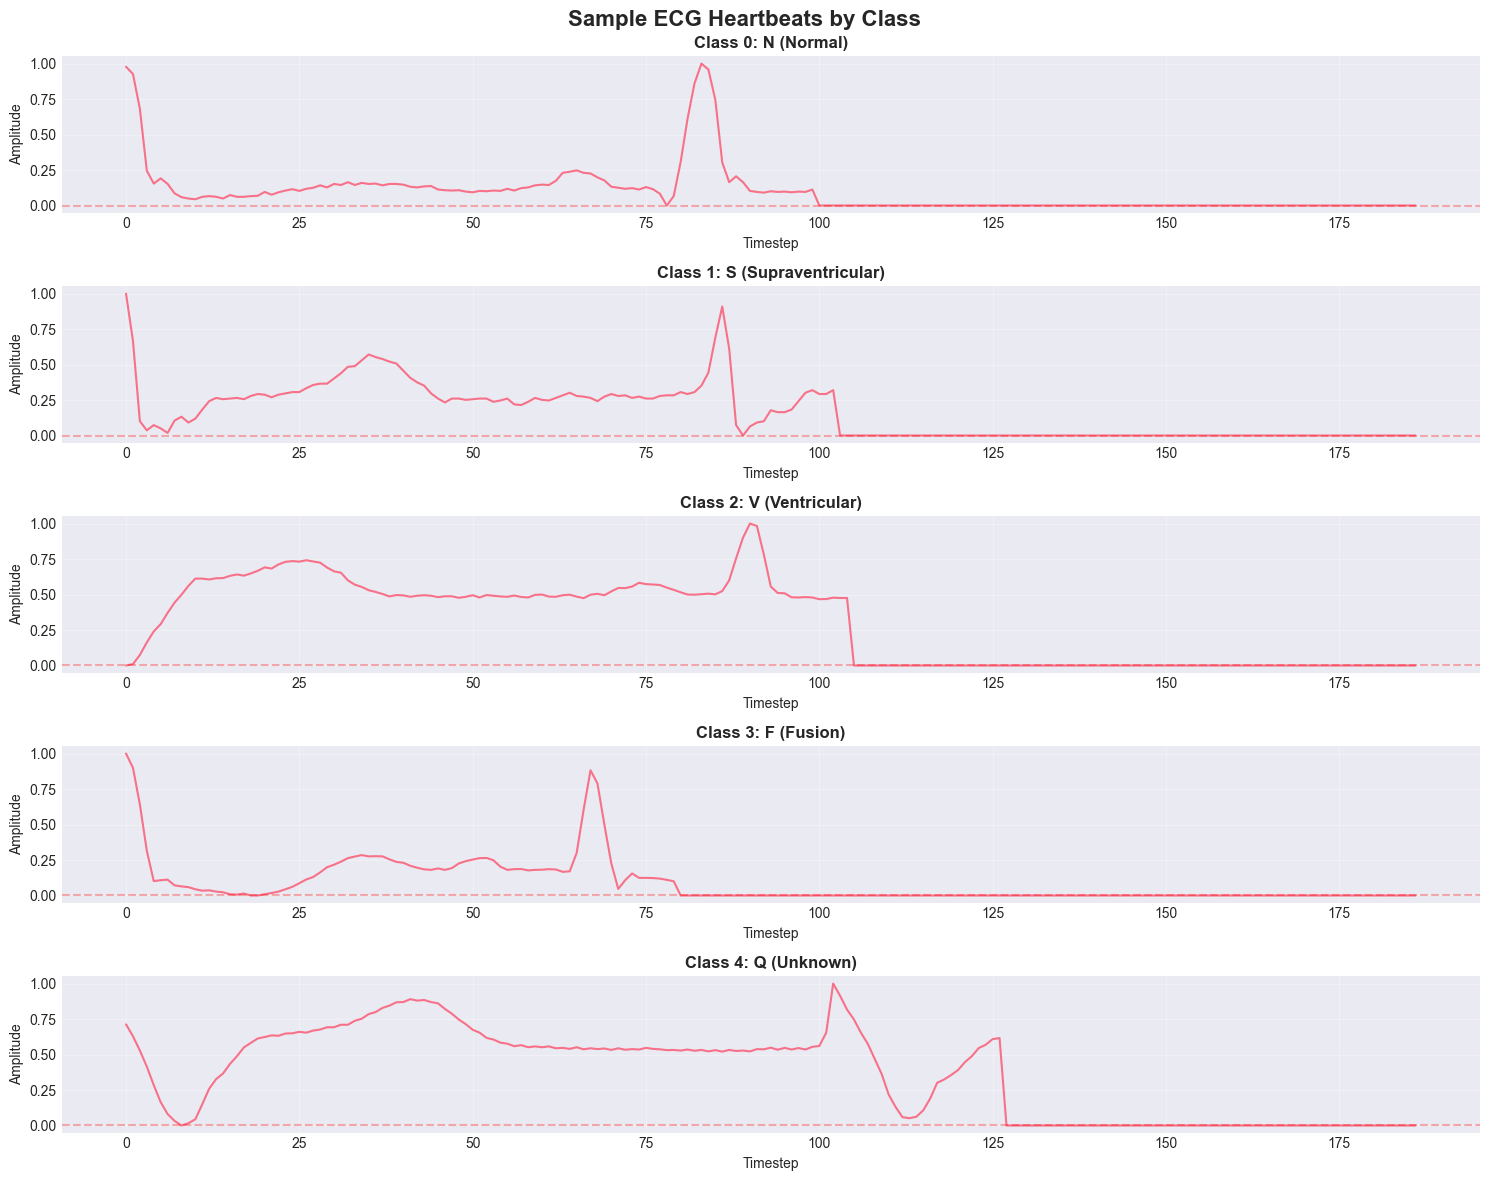

✓ Visual comparison shows different morphological patterns across classes


In [6]:
# Cell 4: Visualize sample ECG signals from each class

fig, axes = plt.subplots(5, 1, figsize=(15, 12))
fig.suptitle('Sample ECG Heartbeats by Class', fontsize=16, fontweight='bold')

for class_id in range(5):
    # Get first sample from this class
    sample_idx = np.where(y_train_full == class_id)[0][0]
    sample_signal = X_train_full[sample_idx]
    
    # Plot
    axes[class_id].plot(sample_signal, linewidth=1.5)
    axes[class_id].set_title(f'Class {class_id}: {class_names[class_id]}', 
                             fontsize=12, fontweight='bold')
    axes[class_id].set_xlabel('Timestep')
    axes[class_id].set_ylabel('Amplitude')
    axes[class_id].grid(True, alpha=0.3)
    axes[class_id].axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visual comparison shows different morphological patterns across classes")

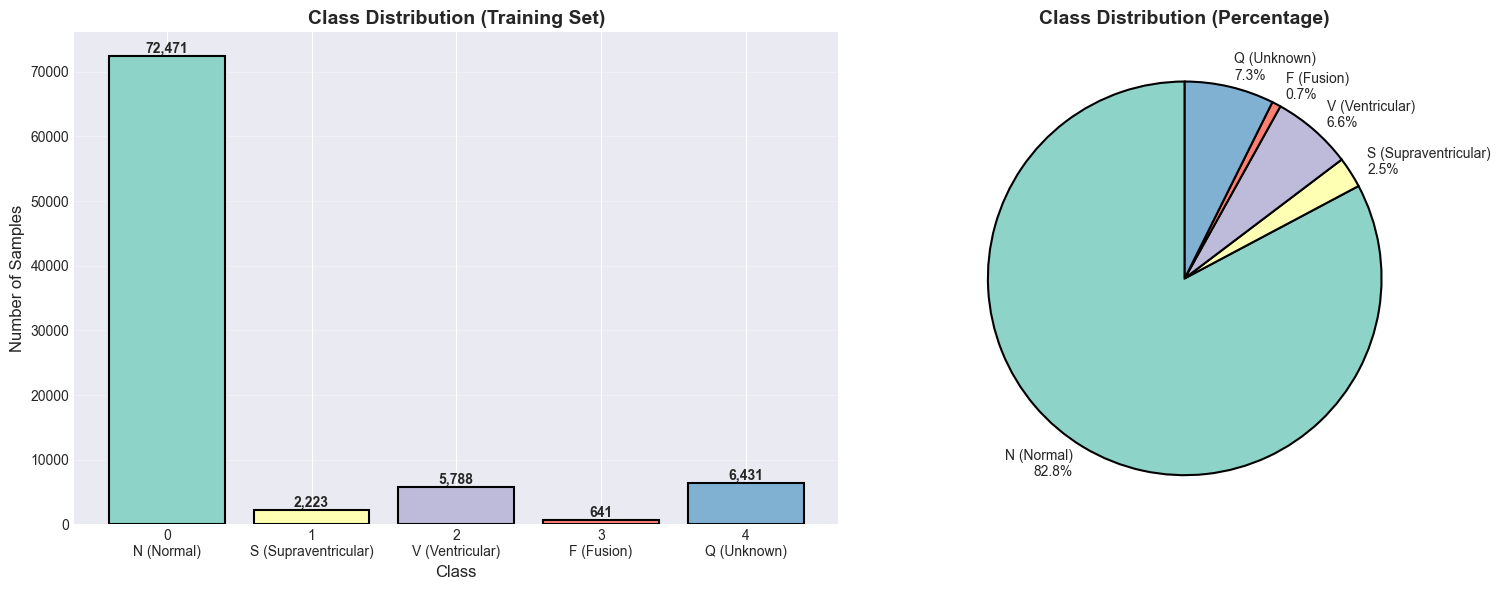


⚠️  Imbalance Ratio: 113.1:1
   (Most common class is 113.1x more frequent than rarest)


In [7]:
# Cell 5: Visualize class imbalance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
classes = [f"{i}\n{class_names[i]}" for i in range(5)]
counts = [class_counts[i] for i in range(5)]
colors = plt.cm.Set3(range(5))

bars = ax1.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Class Distribution (Training Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_xlabel('Class', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pie chart
percentages = [(class_counts[i] / total) * 100 for i in range(5)]
labels = [f"{class_names[i]}\n{percentages[i]:.1f}%" for i in range(5)]

ax2.pie(counts, labels=labels, colors=colors, autopct='', startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_class = max(counts)
min_class = min(counts)
imbalance_ratio = max_class / min_class
print(f"\n⚠️  Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"   (Most common class is {imbalance_ratio:.1f}x more frequent than rarest)")

Normalizing ECG signals...
Method: Standardization (zero mean, unit variance)
✓ Training data normalized
  Original - Mean: 0.1743, Std: 0.2263
  Normalized - Mean: -0.0000, Std: 1.0000
✓ Test data normalized using training statistics


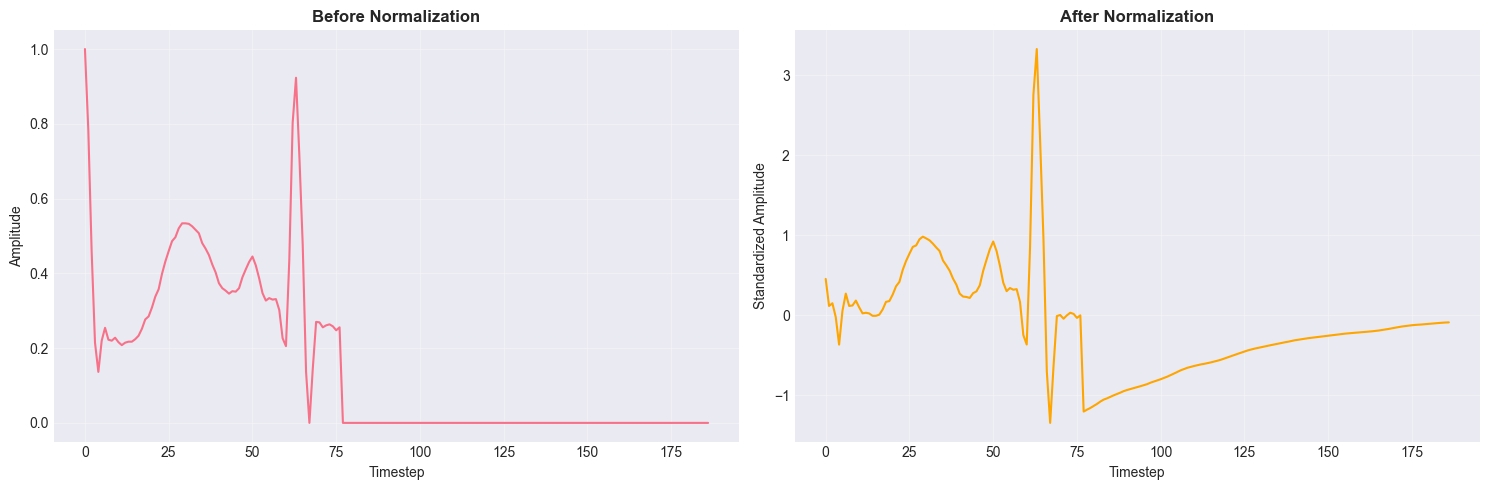

In [8]:
# Cell 6: Normalize ECG signals

print("Normalizing ECG signals...")
print("Method: Standardization (zero mean, unit variance)")

# Calculate mean and std from training data only (avoid data leakage!)
mean = X_train_full.mean(axis=0, keepdims=True)
std = X_train_full.std(axis=0, keepdims=True)

# Add small epsilon to avoid division by zero
epsilon = 1e-8
std = std + epsilon

# Normalize both train and test using training statistics
X_train_normalized = (X_train_full - mean) / std
X_test_normalized = (X_test - mean) / std

print(f"✓ Training data normalized")
print(f"  Original - Mean: {X_train_full.mean():.4f}, Std: {X_train_full.std():.4f}")
print(f"  Normalized - Mean: {X_train_normalized.mean():.4f}, Std: {X_train_normalized.std():.4f}")
print(f"✓ Test data normalized using training statistics")

# Visualize effect of normalization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sample_idx = 100
ax1.plot(X_train_full[sample_idx], linewidth=1.5)
ax1.set_title('Before Normalization', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)

ax2.plot(X_train_normalized[sample_idx], linewidth=1.5, color='orange')
ax2.set_title('After Normalization', fontsize=12, fontweight='bold')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Standardized Amplitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Cell 7: Create train/validation split
# Use stratified split to maintain class distribution

print("Creating train/validation split...")

# Split: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_normalized, 
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Validation set: {len(X_val)} samples")
print(f"✓ Test set: {len(X_test)} samples")

# Verify class distribution is maintained
print("\nClass distribution after split:")
print("-" * 50)
print(f"{'Class':<30} {'Train':<10} {'Val':<10} {'Test':<10}")
print("-" * 50)

for class_id in range(5):
    train_count = np.sum(y_train == class_id)
    val_count = np.sum(y_val == class_id)
    test_count = np.sum(y_test == class_id)
    print(f"{class_names[class_id]:<30} {train_count:<10} {val_count:<10} {test_count:<10}")

print("\n✓ Stratified split maintains class proportions")

Creating train/validation split...
✓ Training set: 70043 samples
✓ Validation set: 17511 samples
✓ Test set: 21892 samples

Class distribution after split:
--------------------------------------------------
Class                          Train      Val        Test      
--------------------------------------------------
N (Normal)                     57977      14494      18118     
S (Supraventricular)           1778       445        556       
V (Ventricular)                4630       1158       1448      
F (Fusion)                     513        128        162       
Q (Unknown)                    5145       1286       1608      

✓ Stratified split maintains class proportions


In [12]:
# Cell 8: Create custom PyTorch Dataset (FIXED)

class ECGDataset(Dataset):
    """
    Custom Dataset for ECG heartbeat classification.
    
    Args:
        data: numpy array of shape (n_samples, 187)
        labels: numpy array of shape (n_samples,)
        transform: optional transforms to apply
    """
    def __init__(self, data, labels, transform=None):
        self.data = torch.FloatTensor(data)
        # Convert float labels to integers
        self.labels = torch.LongTensor(labels.astype(np.int64))
        self.transform = transform
        
        # Reshape to (n_samples, seq_len, features)
        # Currently: (n_samples, 187) → Need: (n_samples, 187, 1)
        self.data = self.data.unsqueeze(-1)  # Add feature dimension
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

# Create datasets
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test_normalized, y_test)

print("✓ PyTorch Datasets created")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")

# Check shapes
sample_data, sample_label = train_dataset[0]
print(f"\n✓ Sample data shape: {sample_data.shape}")
print(f"✓ Sample label: {sample_label.item()}")
print(f"✓ Label dtype: {sample_label.dtype}")

✓ PyTorch Datasets created
  Train dataset size: 70043
  Validation dataset size: 17511
  Test dataset size: 21892

✓ Sample data shape: torch.Size([187, 1])
✓ Sample label: 0
✓ Label dtype: torch.int64


In [13]:
# Cell 9: Create WeightedRandomSampler to handle class imbalance

print("Creating weighted sampler to handle class imbalance...")

# Convert labels to integers (they're currently floats)
y_train_int = y_train.astype(np.int64)
y_val_int = y_val.astype(np.int64)

# Calculate class weights (inverse frequency)
class_counts_train = np.bincount(y_train_int)
class_weights = 1.0 / class_counts_train

print("\nClass weights (inverse frequency):")
for i in range(5):
    print(f"  Class {i} ({class_names[i]}): {class_weights[i]:.6f}")

# Assign weight to each sample based on its class
sample_weights = class_weights[y_train_int]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow replacement to oversample minority classes
)

print("\n✓ Weighted sampler created")
print("  Effect: Minority classes will be sampled more frequently during training")
print("  This helps the model learn patterns from rare arrhythmia types")

# Show the effect of weighting
print("\nExpected sampling effect:")
for i in range(5):
    original_freq = class_counts_train[i] / len(y_train_int) * 100
    weighted_freq = class_weights[i] / class_weights.sum() * 100
    print(f"  Class {i}: Original {original_freq:5.2f}% → Weighted {weighted_freq:5.2f}%")

Creating weighted sampler to handle class imbalance...

Class weights (inverse frequency):
  Class 0 (N (Normal)): 0.000017
  Class 1 (S (Supraventricular)): 0.000562
  Class 2 (V (Ventricular)): 0.000216
  Class 3 (F (Fusion)): 0.001949
  Class 4 (Q (Unknown)): 0.000194

✓ Weighted sampler created
  Effect: Minority classes will be sampled more frequently during training
  This helps the model learn patterns from rare arrhythmia types

Expected sampling effect:
  Class 0: Original 82.77% → Weighted  0.59%
  Class 1: Original  2.54% → Weighted 19.13%
  Class 2: Original  6.61% → Weighted  7.35%
  Class 3: Original  0.73% → Weighted 66.32%
  Class 4: Original  7.35% → Weighted  6.61%


In [16]:
# Cell 10: Create DataLoaders

# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 0 

# Training DataLoader with weighted sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler (don't set shuffle=True with sampler)
    num_workers=NUM_WORKERS,
    pin_memory=False,  # MPS doesn't support pin_memory yet
    persistent_workers=False
)

# Validation DataLoader (no sampler, just shuffle)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False
)

# Test DataLoader (no sampler, no shuffle)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False
)

print("✓ DataLoaders created")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test DataLoader
print("\nTesting DataLoader...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"✓ Sample batch shape: {sample_batch.shape}")  # Should be (64, 187, 1)
print(f"✓ Sample labels shape: {sample_labels.shape}")  # Should be (64,)
print(f"✓ Batch label distribution: {torch.bincount(sample_labels)}")
print("\n✓ DataLoader test successful!")

✓ DataLoaders created
  Batch size: 64
  Training batches: 1095
  Validation batches: 274
  Test batches: 343

Testing DataLoader...
✓ Sample batch shape: torch.Size([64, 187, 1])
✓ Sample labels shape: torch.Size([64])
✓ Batch label distribution: tensor([ 9, 14, 20, 12,  9])

✓ DataLoader test successful!


# Model Architecture Implementation

In [17]:
# Cell 11: Vanilla RNN Architecture

class VanillaRNN(nn.Module):
    """
    Baseline Vanilla RNN for comparison.
    Expected to show vanishing gradient problems on 187-timestep sequences.
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, 
                 num_classes=5, dropout=0.3):
        super(VanillaRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_name = "Vanilla RNN"
        
        # RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
               For our case: (batch_size, 187, 1)
        
        Returns:
            out: Output tensor of shape (batch_size, num_classes)
        """
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        # out: tensor of shape (batch_size, seq_len, hidden_size)
        # hn: tensor of shape (num_layers, batch_size, hidden_size)
        out, hn = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]  # Take last timestep: (batch_size, hidden_size)
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layer
        out = self.fc(out)  # (batch_size, num_classes)
        
        return out

print("✓ Vanilla RNN model defined")

✓ Vanilla RNN model defined


In [18]:
# Cell 12: LSTM Architecture

class LSTMModel(nn.Module):
    """
    LSTM model with forget, input, and output gates.
    Expected to achieve best performance due to cell memory mechanism.
    """
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, 
                 num_classes=5, dropout=0.3):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_name = "LSTM"
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        
        Returns:
            out: Output tensor of shape (batch_size, num_classes)
        """
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out: tensor of shape (batch_size, seq_len, hidden_size)
        # (hn, cn): final hidden and cell states
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layer
        out = self.fc(out)  # (batch_size, num_classes)
        
        return out
    
    def get_cell_states(self, x):
        """
        Utility method to extract cell states for visualization.
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        return {
            'hidden_states': out,      # (batch_size, seq_len, hidden_size)
            'final_hidden': hn,        # (num_layers, batch_size, hidden_size)
            'final_cell': cn           # (num_layers, batch_size, hidden_size)
        }

print("✓ LSTM model defined")

✓ LSTM model defined


In [19]:
# Cell 13: GRU Architecture

class GRUModel(nn.Module):
    """
    GRU model with reset and update gates.
    More efficient than LSTM with comparable performance.
    """
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, 
                 num_classes=5, dropout=0.3):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_name = "GRU"
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        
        Returns:
            out: Output tensor of shape (batch_size, num_classes)
        """
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        # out: tensor of shape (batch_size, seq_len, hidden_size)
        # hn: final hidden state (num_layers, batch_size, hidden_size)
        out, hn = self.gru(x, h0)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layer
        out = self.fc(out)  # (batch_size, num_classes)
        
        return out
    
    def get_gate_activations(self, x):
        """
        Utility method to extract hidden states for visualization.
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.gru(x, h0)
        
        return {
            'hidden_states': out,      # (batch_size, seq_len, hidden_size)
            'final_hidden': hn         # (num_layers, batch_size, hidden_size)
        }

print("✓ GRU model defined")

✓ GRU model defined


In [20]:
# Cell 14: Model Summary and Parameter Count Function

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_summary(model):
    """Print detailed model summary."""
    print("="*70)
    print(f"MODEL: {model.model_name}")
    print("="*70)
    print(model)
    print("="*70)
    
    # Count parameters
    total_params = count_parameters(model)
    print(f"Total Trainable Parameters: {total_params:,}")
    
    # Calculate model size in MB
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024**2
    print(f"Model Size: {size_mb:.2f} MB")
    print("="*70)
    print()

# Test with sample input to verify shapes
def test_model_forward(model, input_shape=(2, 187, 1)):
    """Test model forward pass with dummy input."""
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)
    
    with torch.no_grad():
        output = model(dummy_input)
    
    print(f"✓ Forward pass successful for {model.model_name}")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Expected output shape: (batch_size={input_shape[0]}, num_classes=5)")
    
    return output

print("✓ Model summary functions defined")

✓ Model summary functions defined


In [21]:
# Cell 15: Create model instances and test

# Hyperparameters
INPUT_SIZE = 1
HIDDEN_SIZE_RNN = 64   # Smaller for vanilla RNN
HIDDEN_SIZE_LSTM = 128  # Larger for LSTM/GRU
NUM_LAYERS = 2
NUM_CLASSES = 5
DROPOUT = 0.3

print("Creating model instances...\n")

# Instantiate Vanilla RNN
vanilla_rnn = VanillaRNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE_RNN,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

# Instantiate LSTM
lstm_model = LSTMModel(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE_LSTM,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

# Instantiate GRU
gru_model = GRUModel(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE_LSTM,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

print("✓ All models created and moved to device:", device)
print("\n" + "="*70)
print("MODEL SUMMARIES")
print("="*70 + "\n")

# Print summaries
print_model_summary(vanilla_rnn)
print_model_summary(lstm_model)
print_model_summary(gru_model)

# Test forward passes
print("="*70)
print("TESTING FORWARD PASSES")
print("="*70 + "\n")

test_model_forward(vanilla_rnn)
print()
test_model_forward(lstm_model)
print()
test_model_forward(gru_model)

print("\n" + "="*70)
print("PARAMETER COMPARISON")
print("="*70)

models_info = [
    ("Vanilla RNN", count_parameters(vanilla_rnn)),
    ("LSTM", count_parameters(lstm_model)),
    ("GRU", count_parameters(gru_model))
]

for name, params in models_info:
    print(f"{name:15s}: {params:>10,} parameters")

# Calculate efficiency
lstm_params = count_parameters(lstm_model)
gru_params = count_parameters(gru_model)
rnn_params = count_parameters(vanilla_rnn)

print(f"\nGRU is {(1 - gru_params/lstm_params)*100:.1f}% smaller than LSTM")
print(f"LSTM is {(lstm_params/rnn_params):.1f}x larger than Vanilla RNN")

print("\n✓ All models initialized and tested successfully!")

Creating model instances...

✓ All models created and moved to device: mps

MODEL SUMMARIES

MODEL: Vanilla RNN
VanillaRNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)
Total Trainable Parameters: 12,933
Model Size: 0.05 MB

MODEL: LSTM
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Total Trainable Parameters: 199,813
Model Size: 0.76 MB

MODEL: GRU
GRUModel(
  (gru): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Total Trainable Parameters: 150,021
Model Size: 0.57 MB

TESTING FORWARD PASSES

✓ Forward pass successful for Vanilla RNN
  Input shape: torch.Size([2, 187, 1])
  Output shape: torch.Size([2, 5])
  Expected o

In [22]:
# Cell 16: Training and Evaluation Functions

def train_one_epoch(model, train_loader, criterion, optimizer, device, grad_clip=None):
    """
    Train the model for one epoch.
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on (mps/cpu)
        grad_clip: Gradient clipping value (None = no clipping)
    
    Returns:
        avg_loss: Average loss for the epoch
        accuracy: Training accuracy
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (if specified)
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion, device):
    """
    Evaluate the model on validation or test set.
    
    Args:
        model: The neural network model
        data_loader: DataLoader for evaluation data
        criterion: Loss function
        device: Device to evaluate on
    
    Returns:
        avg_loss: Average loss
        accuracy: Accuracy
        all_preds: All predictions
        all_targets: All true labels
    """
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in data_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Store predictions and targets
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_preds, all_targets


def calculate_metrics(y_true, y_pred):
    """
    Calculate detailed metrics: precision, recall, F1 for each class.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
    
    Returns:
        metrics_dict: Dictionary with detailed metrics
    """
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class and macro metrics
    report = classification_report(y_true, y_pred, output_dict=True, 
                                   target_names=[class_names[i] for i in range(5)],
                                   zero_division=0)
    
    metrics_dict = {
        'accuracy': accuracy,
        'macro_f1': report['macro avg']['f1-score'],
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall'],
        'per_class_report': report
    }
    
    return metrics_dict

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


In [23]:
# Cell 17: Loss Function and Optimizer Configuration

# Cross Entropy Loss (suitable for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Learning rate
LEARNING_RATE = 0.001

# Create optimizers for each model
optimizer_rnn = optim.Adam(vanilla_rnn.parameters(), lr=LEARNING_RATE)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
optimizer_gru = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

print("✓ Loss function and optimizers configured")
print(f"  Loss Function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning Rate: {LEARNING_RATE}")

✓ Loss function and optimizers configured
  Loss Function: CrossEntropyLoss
  Optimizer: Adam
  Learning Rate: 0.001


In [25]:
# Cell 18: Learning Rate Scheduler Setup (FIXED)

# ReduceLROnPlateau: Reduces learning rate when validation loss plateaus
scheduler_rnn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_rnn,
    mode='min',           # Minimize validation loss
    factor=0.5,           # Reduce LR by 50%
    patience=5,           # Wait 5 epochs before reducing
    min_lr=1e-6          # Don't reduce below this value
)

scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_lstm,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_gru,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("✓ Learning rate schedulers configured")
print("  Type: ReduceLROnPlateau")
print("  Reduction Factor: 0.5 (50% reduction)")
print("  Patience: 5 epochs")
print("  Minimum LR: 1e-6")
print("\n  Note: LR reductions will be printed during training")

✓ Learning rate schedulers configured
  Type: ReduceLROnPlateau
  Reduction Factor: 0.5 (50% reduction)
  Patience: 5 epochs
  Minimum LR: 1e-6

  Note: LR reductions will be printed during training


In [26]:
# Cell 19: Training Configuration

# Training hyperparameters
NUM_EPOCHS = 50
GRAD_CLIP = 1.0  # Gradient clipping threshold
EARLY_STOP_PATIENCE = 10  # Stop if no improvement for 10 epochs

# Dictionary to store training history
history = {
    'vanilla_rnn': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
    'lstm': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
    'gru': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
}

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Gradient Clipping: {GRAD_CLIP}")
print(f"Early Stopping Patience: {EARLY_STOP_PATIENCE}")
print(f"Device: {device}")
print("="*70)

TRAINING CONFIGURATION
Number of Epochs: 50
Batch Size: 64
Learning Rate: 0.001
Gradient Clipping: 1.0
Early Stopping Patience: 10
Device: mps


In [27]:
# Cell 20: Train Vanilla RNN (UPDATED with LR logging)

print("\n" + "="*70)
print("TRAINING VANILLA RNN")
print("="*70 + "\n")

best_val_loss = float('inf')
patience_counter = 0
current_lr = LEARNING_RATE

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        vanilla_rnn, train_loader, criterion, optimizer_rnn, device, grad_clip=GRAD_CLIP
    )
    
    # Evaluate on validation set
    val_loss, val_acc, _, _ = evaluate(
        vanilla_rnn, val_loader, criterion, device
    )
    
    # Store history
    history['vanilla_rnn']['train_loss'].append(train_loss)
    history['vanilla_rnn']['train_acc'].append(train_acc)
    history['vanilla_rnn']['val_loss'].append(val_loss)
    history['vanilla_rnn']['val_acc'].append(val_acc)
    
    # Get current learning rate before scheduler step
    old_lr = optimizer_rnn.param_groups[0]['lr']
    
    # Update learning rate scheduler
    scheduler_rnn.step(val_loss)
    
    # Get new learning rate after scheduler step
    new_lr = optimizer_rnn.param_groups[0]['lr']
    
    # Check if learning rate was reduced
    if new_lr < old_lr:
        print(f"\n📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}\n")
    
    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(vanilla_rnn.state_dict(), 'best_vanilla_rnn.pth')
        print(f"   ⭐ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation loss: {best_val_loss:.4f}")
            break

print("\n✓ Vanilla RNN training completed")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Best Validation Accuracy: {max(history['vanilla_rnn']['val_acc']):.2f}%")


TRAINING VANILLA RNN

Epoch [1/50] (67.84s) - Train Loss: 1.5100, Train Acc: 29.28% | Val Loss: 1.5762, Val Acc: 8.15%
   ⭐ New best model saved!
Epoch [2/50] (64.12s) - Train Loss: 1.4610, Train Acc: 33.60% | Val Loss: 1.5020, Val Acc: 7.84%
   ⭐ New best model saved!
Epoch [3/50] (65.16s) - Train Loss: 1.5075, Train Acc: 29.29% | Val Loss: 1.6977, Val Acc: 8.25%
Epoch [4/50] (63.91s) - Train Loss: 1.4328, Train Acc: 36.59% | Val Loss: 1.7379, Val Acc: 8.10%
Epoch [5/50] (63.56s) - Train Loss: 1.5017, Train Acc: 29.71% | Val Loss: 1.5434, Val Acc: 3.52%
Epoch [6/50] (63.44s) - Train Loss: 1.4917, Train Acc: 32.68% | Val Loss: 1.5291, Val Acc: 8.95%
Epoch [7/50] (62.93s) - Train Loss: 1.4794, Train Acc: 33.18% | Val Loss: 1.5050, Val Acc: 67.92%
Epoch [8/50] (62.69s) - Train Loss: 1.4657, Train Acc: 34.73% | Val Loss: 1.3837, Val Acc: 40.28%
   ⭐ New best model saved!
Epoch [9/50] (61.40s) - Train Loss: 1.5598, Train Acc: 28.22% | Val Loss: 1.5369, Val Acc: 30.42%
Epoch [10/50] (61.94

In [28]:
# Cell 21: Train LSTM (UPDATED with LR logging)

print("\n" + "="*70)
print("TRAINING LSTM")
print("="*70 + "\n")

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        lstm_model, train_loader, criterion, optimizer_lstm, device, grad_clip=GRAD_CLIP
    )
    
    # Evaluate on validation set
    val_loss, val_acc, _, _ = evaluate(
        lstm_model, val_loader, criterion, device
    )
    
    # Store history
    history['lstm']['train_loss'].append(train_loss)
    history['lstm']['train_acc'].append(train_acc)
    history['lstm']['val_loss'].append(val_loss)
    history['lstm']['val_acc'].append(val_acc)
    
    # Get current learning rate before scheduler step
    old_lr = optimizer_lstm.param_groups[0]['lr']
    
    # Update learning rate scheduler
    scheduler_lstm.step(val_loss)
    
    # Get new learning rate after scheduler step
    new_lr = optimizer_lstm.param_groups[0]['lr']
    
    # Check if learning rate was reduced
    if new_lr < old_lr:
        print(f"\n📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}\n")
    
    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(lstm_model.state_dict(), 'best_lstm.pth')
        print(f"   ⭐ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation loss: {best_val_loss:.4f}")
            break

print("\n✓ LSTM training completed")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Best Validation Accuracy: {max(history['lstm']['val_acc']):.2f}%")


TRAINING LSTM

Epoch [1/50] (21.64s) - Train Loss: 1.3572, Train Acc: 39.79% | Val Loss: 1.3328, Val Acc: 28.44%
   ⭐ New best model saved!
Epoch [2/50] (19.89s) - Train Loss: 0.8110, Train Acc: 70.98% | Val Loss: 0.8556, Val Acc: 71.20%
   ⭐ New best model saved!
Epoch [3/50] (19.82s) - Train Loss: 0.5705, Train Acc: 80.33% | Val Loss: 0.6117, Val Acc: 83.64%
   ⭐ New best model saved!
Epoch [4/50] (19.69s) - Train Loss: 0.4345, Train Acc: 84.89% | Val Loss: 0.5737, Val Acc: 84.40%
   ⭐ New best model saved!
Epoch [5/50] (19.65s) - Train Loss: 0.3560, Train Acc: 87.56% | Val Loss: 0.4402, Val Acc: 86.33%
   ⭐ New best model saved!
Epoch [6/50] (19.65s) - Train Loss: 0.3057, Train Acc: 89.26% | Val Loss: 0.3908, Val Acc: 86.76%
   ⭐ New best model saved!
Epoch [7/50] (19.52s) - Train Loss: 0.2777, Train Acc: 90.40% | Val Loss: 0.3070, Val Acc: 90.90%
   ⭐ New best model saved!
Epoch [8/50] (19.74s) - Train Loss: 0.2464, Train Acc: 91.46% | Val Loss: 0.2601, Val Acc: 91.32%
   ⭐ New be

In [29]:
# Cell 22: Train GRU (UPDATED with LR logging)

print("\n" + "="*70)
print("TRAINING GRU")
print("="*70 + "\n")

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        gru_model, train_loader, criterion, optimizer_gru, device, grad_clip=GRAD_CLIP
    )
    
    # Evaluate on validation set
    val_loss, val_acc, _, _ = evaluate(
        gru_model, val_loader, criterion, device
    )
    
    # Store history
    history['gru']['train_loss'].append(train_loss)
    history['gru']['train_acc'].append(train_acc)
    history['gru']['val_loss'].append(val_loss)
    history['gru']['val_acc'].append(val_acc)
    
    # Get current learning rate before scheduler step
    old_lr = optimizer_gru.param_groups[0]['lr']
    
    # Update learning rate scheduler
    scheduler_gru.step(val_loss)
    
    # Get new learning rate after scheduler step
    new_lr = optimizer_gru.param_groups[0]['lr']
    
    # Check if learning rate was reduced
    if new_lr < old_lr:
        print(f"\n📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}\n")
    
    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(gru_model.state_dict(), 'best_gru.pth')
        print(f"   ⭐ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation loss: {best_val_loss:.4f}")
            break

print("\n✓ GRU training completed")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Best Validation Accuracy: {max(history['gru']['val_acc']):.2f}%")

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*70)


TRAINING GRU

Epoch [1/50] (122.66s) - Train Loss: 1.2745, Train Acc: 45.09% | Val Loss: 1.3678, Val Acc: 41.72%
   ⭐ New best model saved!
Epoch [2/50] (118.96s) - Train Loss: 0.4929, Train Acc: 82.80% | Val Loss: 0.5385, Val Acc: 83.06%
   ⭐ New best model saved!
Epoch [3/50] (120.81s) - Train Loss: 0.3089, Train Acc: 89.20% | Val Loss: 0.4025, Val Acc: 87.09%
   ⭐ New best model saved!
Epoch [4/50] (121.23s) - Train Loss: 0.2398, Train Acc: 91.54% | Val Loss: 0.3773, Val Acc: 86.69%
   ⭐ New best model saved!
Epoch [5/50] (119.73s) - Train Loss: 0.1970, Train Acc: 93.27% | Val Loss: 0.2972, Val Acc: 89.53%
   ⭐ New best model saved!
Epoch [6/50] (121.00s) - Train Loss: 0.1625, Train Acc: 94.49% | Val Loss: 0.2260, Val Acc: 91.61%
   ⭐ New best model saved!
Epoch [7/50] (121.11s) - Train Loss: 0.1375, Train Acc: 95.40% | Val Loss: 0.1906, Val Acc: 93.30%
   ⭐ New best model saved!
Epoch [8/50] (119.35s) - Train Loss: 0.1175, Train Acc: 96.11% | Val Loss: 0.1755, Val Acc: 94.03%
   ⭐

In [30]:
# Cell 23: Load best models and evaluate on test set

print("="*70)
print("LOADING BEST MODELS AND EVALUATING ON TEST SET")
print("="*70 + "\n")

# Load best model weights
vanilla_rnn.load_state_dict(torch.load('best_vanilla_rnn.pth'))
lstm_model.load_state_dict(torch.load('best_lstm.pth'))
gru_model.load_state_dict(torch.load('best_gru.pth'))

print("✓ Best model weights loaded\n")

# Evaluate all models on test set
models = {
    'Vanilla RNN': vanilla_rnn,
    'LSTM': lstm_model,
    'GRU': gru_model
}

test_results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)
    metrics = calculate_metrics(y_true, y_pred)
    
    test_results[name] = {
        'loss': test_loss,
        'accuracy': test_acc,
        'y_pred': y_pred,
        'y_true': y_true,
        'metrics': metrics
    }
    
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    print(f"  Macro F1-Score: {metrics['macro_f1']:.4f}")
    print()

print("="*70)
print("TEST SET RESULTS SUMMARY")
print("="*70)
print(f"{'Model':<15} {'Accuracy':<12} {'Macro F1':<12} {'Loss':<10}")
print("-"*70)
for name, results in test_results.items():
    print(f"{name:<15} {results['accuracy']:<12.2f} {results['metrics']['macro_f1']:<12.4f} {results['loss']:<10.4f}")
print("="*70)

LOADING BEST MODELS AND EVALUATING ON TEST SET

✓ Best model weights loaded

Evaluating Vanilla RNN...
  Test Loss: 1.3921
  Test Accuracy: 39.93%
  Macro F1-Score: 0.2056

Evaluating LSTM...
  Test Loss: 0.1330
  Test Accuracy: 96.76%
  Macro F1-Score: 0.8588

Evaluating GRU...
  Test Loss: 0.1141
  Test Accuracy: 97.73%
  Macro F1-Score: 0.8955

TEST SET RESULTS SUMMARY
Model           Accuracy     Macro F1     Loss      
----------------------------------------------------------------------
Vanilla RNN     39.93        0.2056       1.3921    
LSTM            96.76        0.8588       0.1330    
GRU             97.73        0.8955       0.1141    


In [31]:
# Cell 24: Create detailed metrics comparison table

print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70 + "\n")

for model_name, results in test_results.items():
    print(f"\n{'='*70}")
    print(f"{model_name.upper()}")
    print(f"{'='*70}")
    
    report = results['metrics']['per_class_report']
    
    # Print per-class metrics
    print(f"\n{'Class':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*70)
    
    for i in range(5):
        class_label = class_names[i]
        if class_label in report:
            p = report[class_label]['precision']
            r = report[class_label]['recall']
            f1 = report[class_label]['f1-score']
            support = report[class_label]['support']
            print(f"{class_label:<30} {p:<12.4f} {r:<12.4f} {f1:<12.4f} {support:<10.0f}")
    
    print("-"*70)
    print(f"{'Macro Average':<30} {results['metrics']['macro_precision']:<12.4f} "
          f"{results['metrics']['macro_recall']:<12.4f} {results['metrics']['macro_f1']:<12.4f}")
    print(f"{'Overall Accuracy':<30} {results['accuracy']:.2f}%")
    print()


DETAILED PERFORMANCE METRICS


VANILLA RNN

Class                          Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
N (Normal)                     0.9033       0.4030       0.5573       18118     
S (Supraventricular)           0.0413       0.7446       0.0782       556       
V (Ventricular)                0.2963       0.0055       0.0108       1448      
F (Fusion)                     0.0000       0.0000       0.0000       162       
Q (Unknown)                    0.2734       0.6331       0.3818       1608      
----------------------------------------------------------------------
Macro Average                  0.3028       0.3572       0.2056      
Overall Accuracy               39.93%


LSTM

Class                          Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
N (Normal)                     0.9923       0.9727       0.

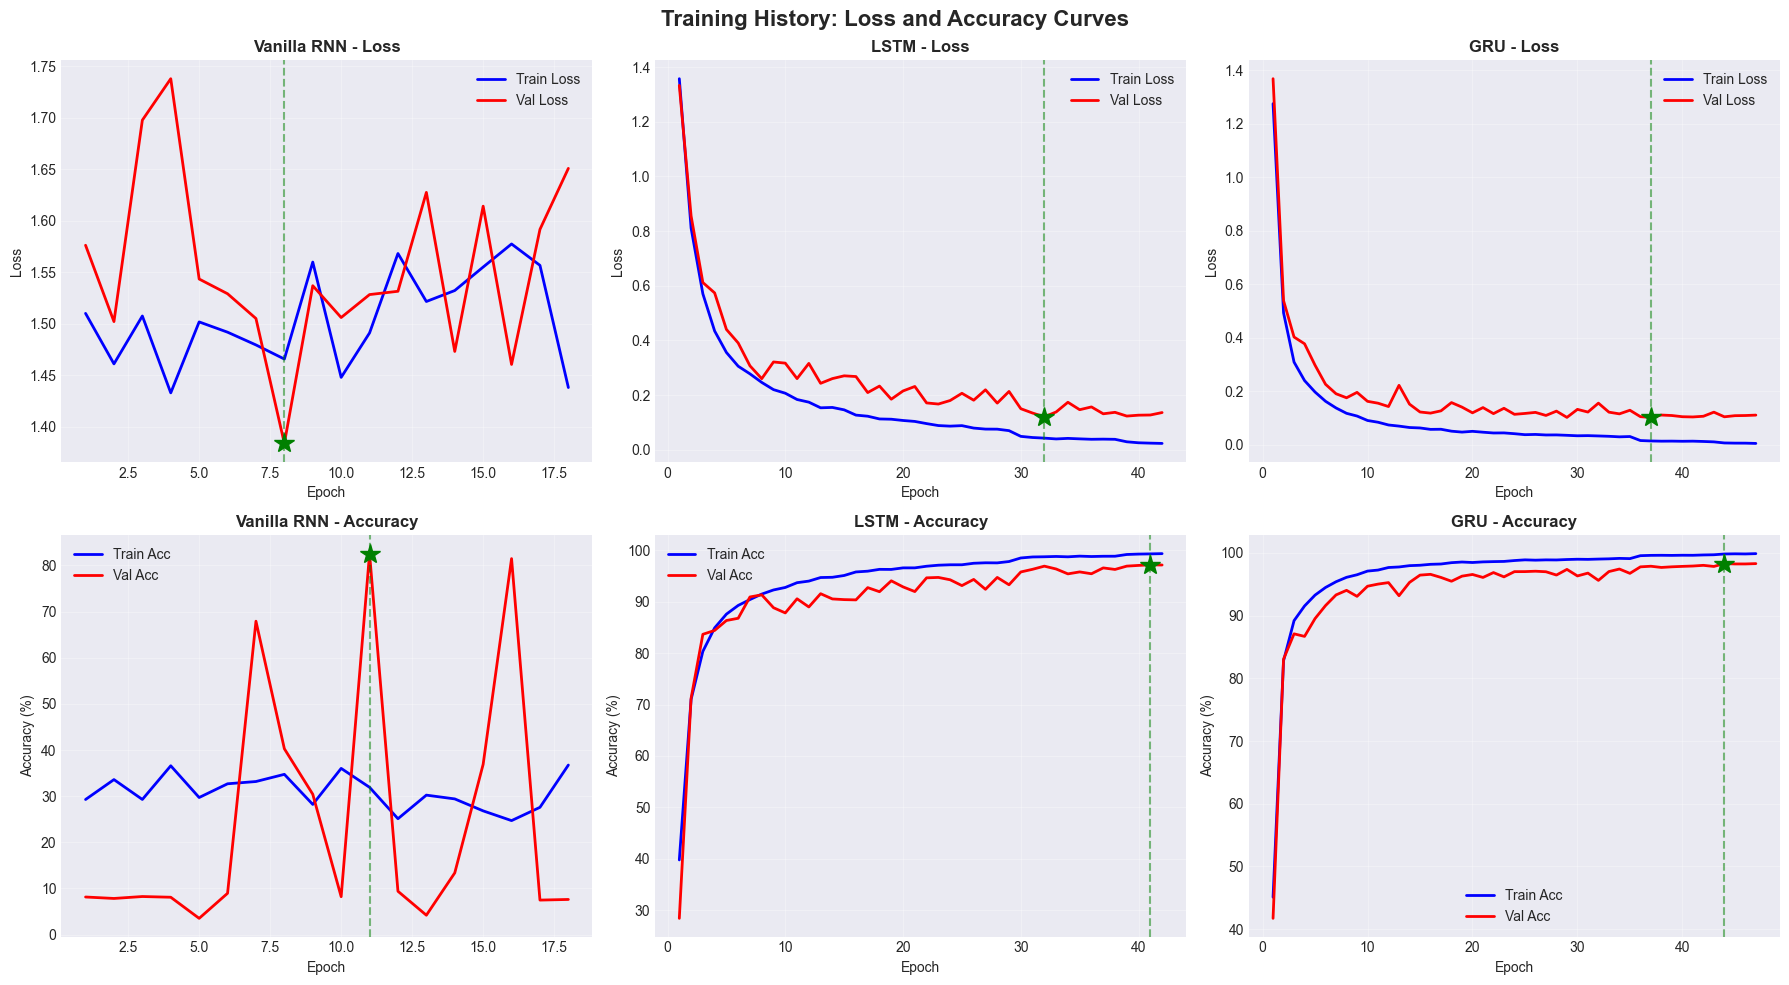

✓ Training history visualized


In [32]:
# Cell 25: Plot training history (loss and accuracy curves)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History: Loss and Accuracy Curves', fontsize=16, fontweight='bold')

models_list = ['vanilla_rnn', 'lstm', 'gru']
titles = ['Vanilla RNN', 'LSTM', 'GRU']

for idx, (model_key, title) in enumerate(zip(models_list, titles)):
    # Loss plot
    ax_loss = axes[0, idx]
    epochs = range(1, len(history[model_key]['train_loss']) + 1)
    
    ax_loss.plot(epochs, history[model_key]['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax_loss.plot(epochs, history[model_key]['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax_loss.set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    
    # Mark best epoch
    best_epoch = np.argmin(history[model_key]['val_loss']) + 1
    best_val_loss = min(history[model_key]['val_loss'])
    ax_loss.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch}')
    ax_loss.plot(best_epoch, best_val_loss, 'g*', markersize=15)
    
    # Accuracy plot
    ax_acc = axes[1, idx]
    ax_acc.plot(epochs, history[model_key]['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax_acc.plot(epochs, history[model_key]['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax_acc.set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    
    # Mark best epoch
    best_epoch_acc = np.argmax(history[model_key]['val_acc']) + 1
    best_val_acc = max(history[model_key]['val_acc'])
    ax_acc.axvline(x=best_epoch_acc, color='g', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch_acc}')
    ax_acc.plot(best_epoch_acc, best_val_acc, 'g*', markersize=15)

plt.tight_layout()
plt.show()

print("✓ Training history visualized")

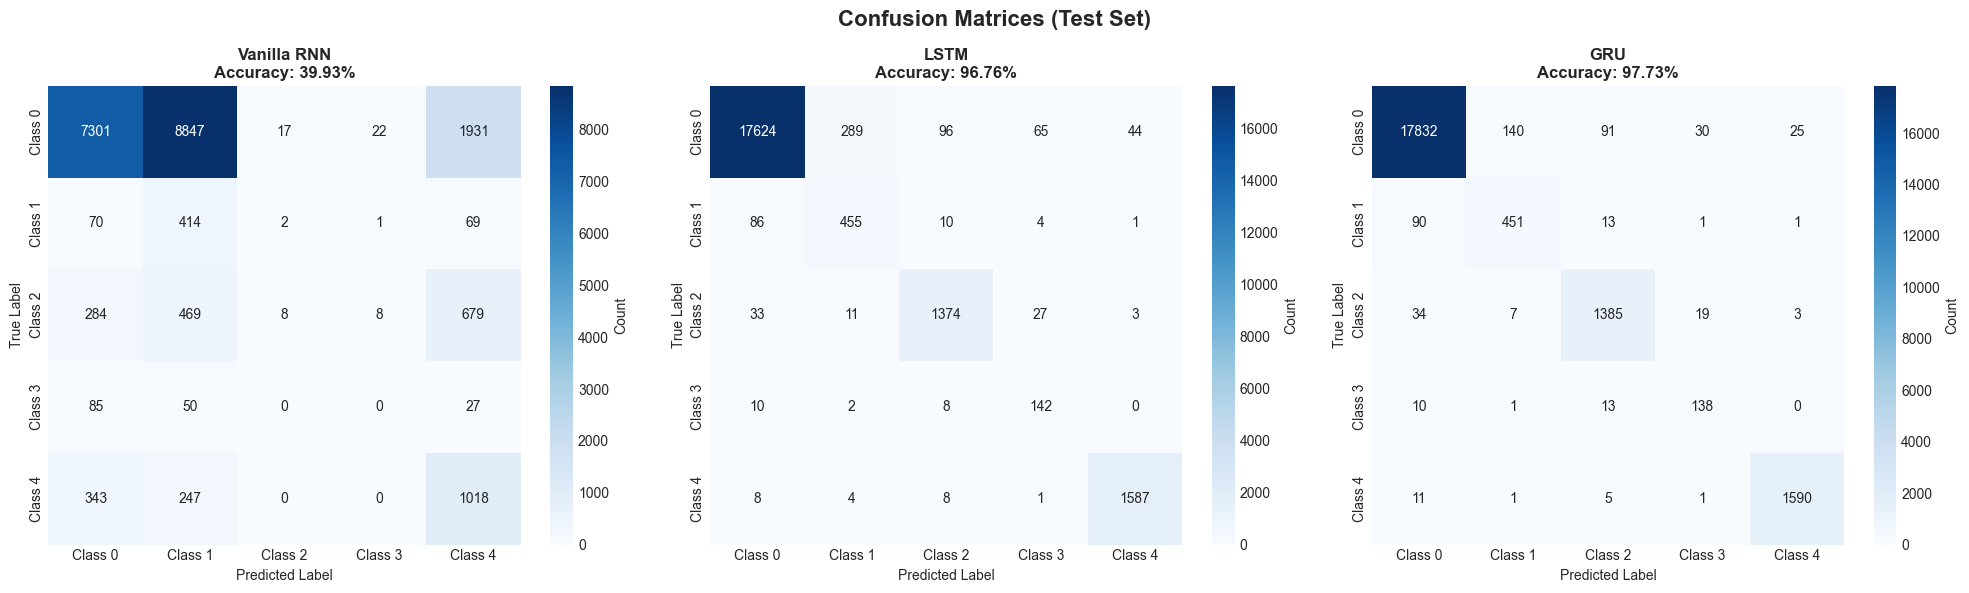

✓ Confusion matrices plotted


In [33]:
# Cell 26: Plot confusion matrices for all models

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices (Test Set)', fontsize=16, fontweight='bold')

for idx, (model_name, results) in enumerate(test_results.items()):
    y_true = results['y_true']
    y_pred = results['y_pred']
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=[f'Class {i}' for i in range(5)],
                yticklabels=[f'Class {i}' for i in range(5)],
                cbar_kws={'label': 'Count'})
    
    ax.set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.2f}%', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted")

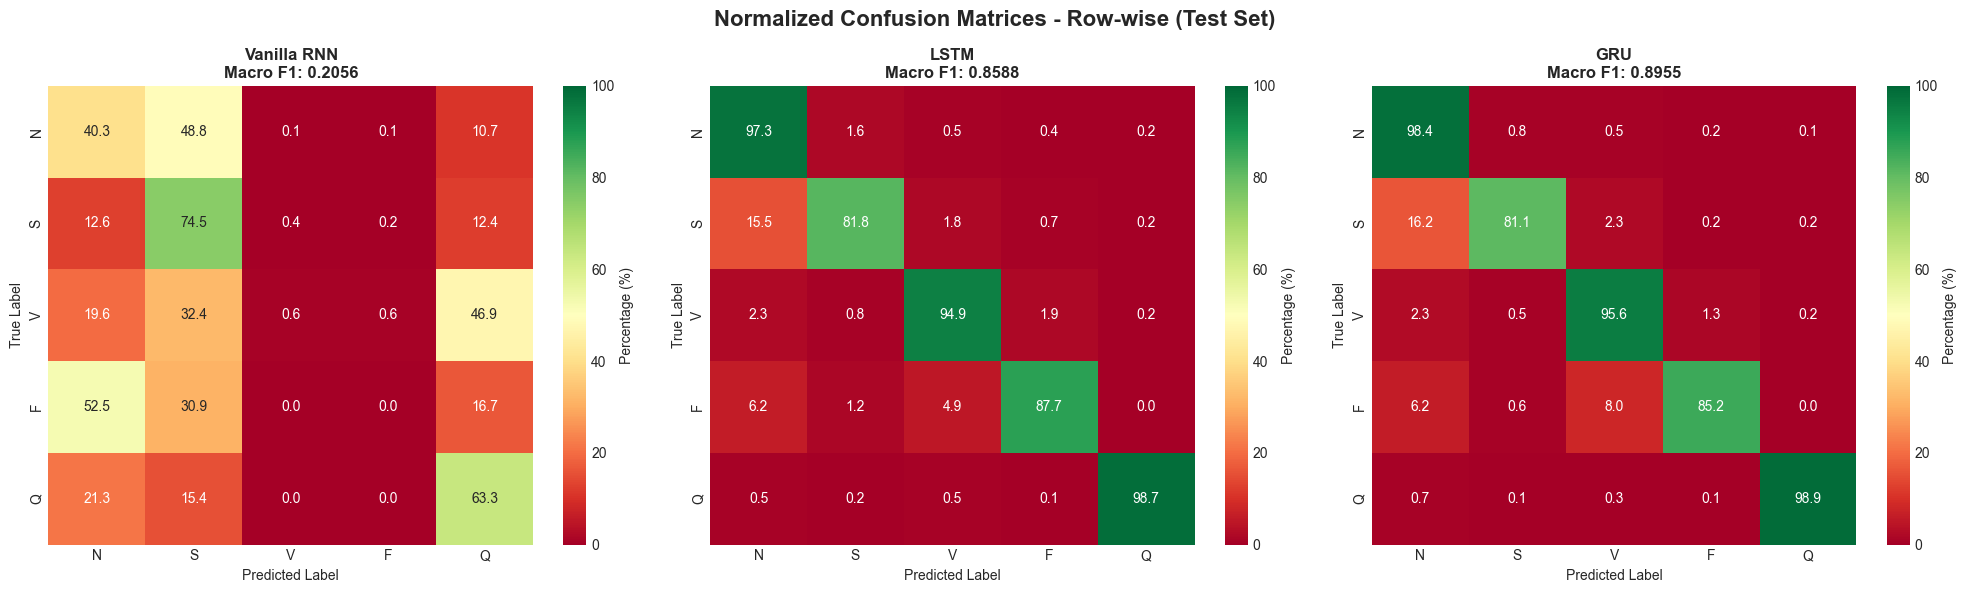

✓ Normalized confusion matrices plotted

Interpretation: Diagonal values show recall (% of true class correctly predicted)
High diagonal values = good performance for that class


In [34]:
# Cell 27: Plot normalized confusion matrices (percentages)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Normalized Confusion Matrices - Row-wise (Test Set)', fontsize=16, fontweight='bold')

class_labels_short = ['N', 'S', 'V', 'F', 'Q']

for idx, (model_name, results) in enumerate(test_results.items()):
    y_true = results['y_true']
    y_pred = results['y_pred']
    
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot
    ax = axes[idx]
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
                xticklabels=class_labels_short,
                yticklabels=class_labels_short,
                cbar_kws={'label': 'Percentage (%)'},
                vmin=0, vmax=100)
    
    ax.set_title(f'{model_name}\nMacro F1: {results["metrics"]["macro_f1"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("✓ Normalized confusion matrices plotted")
print("\nInterpretation: Diagonal values show recall (% of true class correctly predicted)")
print("High diagonal values = good performance for that class")

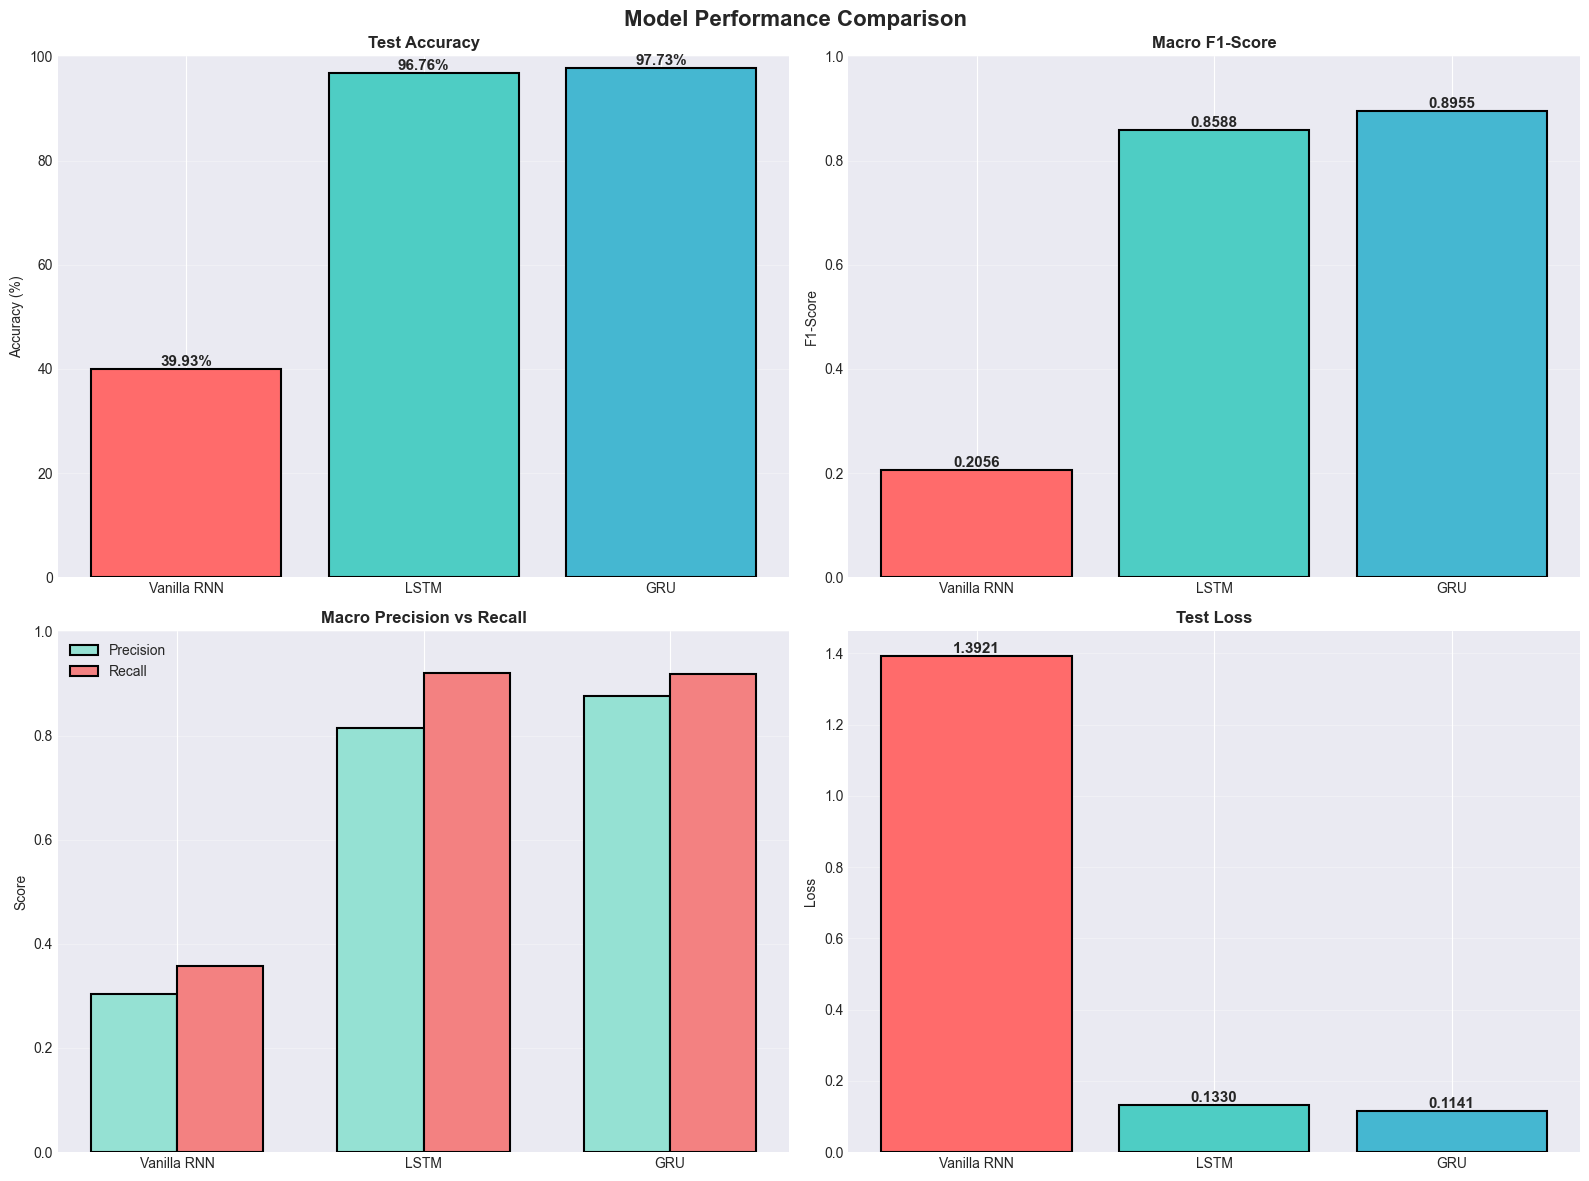

✓ Model comparison visualized


In [35]:
# Cell 28: Compare models across all metrics

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

model_names_list = list(test_results.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Overall Accuracy
ax1 = axes[0, 0]
accuracies = [test_results[name]['accuracy'] for name in model_names_list]
bars = ax1.bar(model_names_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Macro F1-Score
ax2 = axes[0, 1]
macro_f1s = [test_results[name]['metrics']['macro_f1'] for name in model_names_list]
bars = ax2.bar(model_names_list, macro_f1s, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_title('Macro F1-Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Precision and Recall
ax3 = axes[1, 0]
precisions = [test_results[name]['metrics']['macro_precision'] for name in model_names_list]
recalls = [test_results[name]['metrics']['macro_recall'] for name in model_names_list]

x = np.arange(len(model_names_list))
width = 0.35

bars1 = ax3.bar(x - width/2, precisions, width, label='Precision', 
                color='#95E1D3', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x + width/2, recalls, width, label='Recall',
                color='#F38181', edgecolor='black', linewidth=1.5)

ax3.set_title('Macro Precision vs Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels(model_names_list)
ax3.set_ylim([0, 1])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Test Loss
ax4 = axes[1, 1]
losses = [test_results[name]['loss'] for name in model_names_list]
bars = ax4.bar(model_names_list, losses, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_title('Test Loss', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss')
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Model comparison visualized")

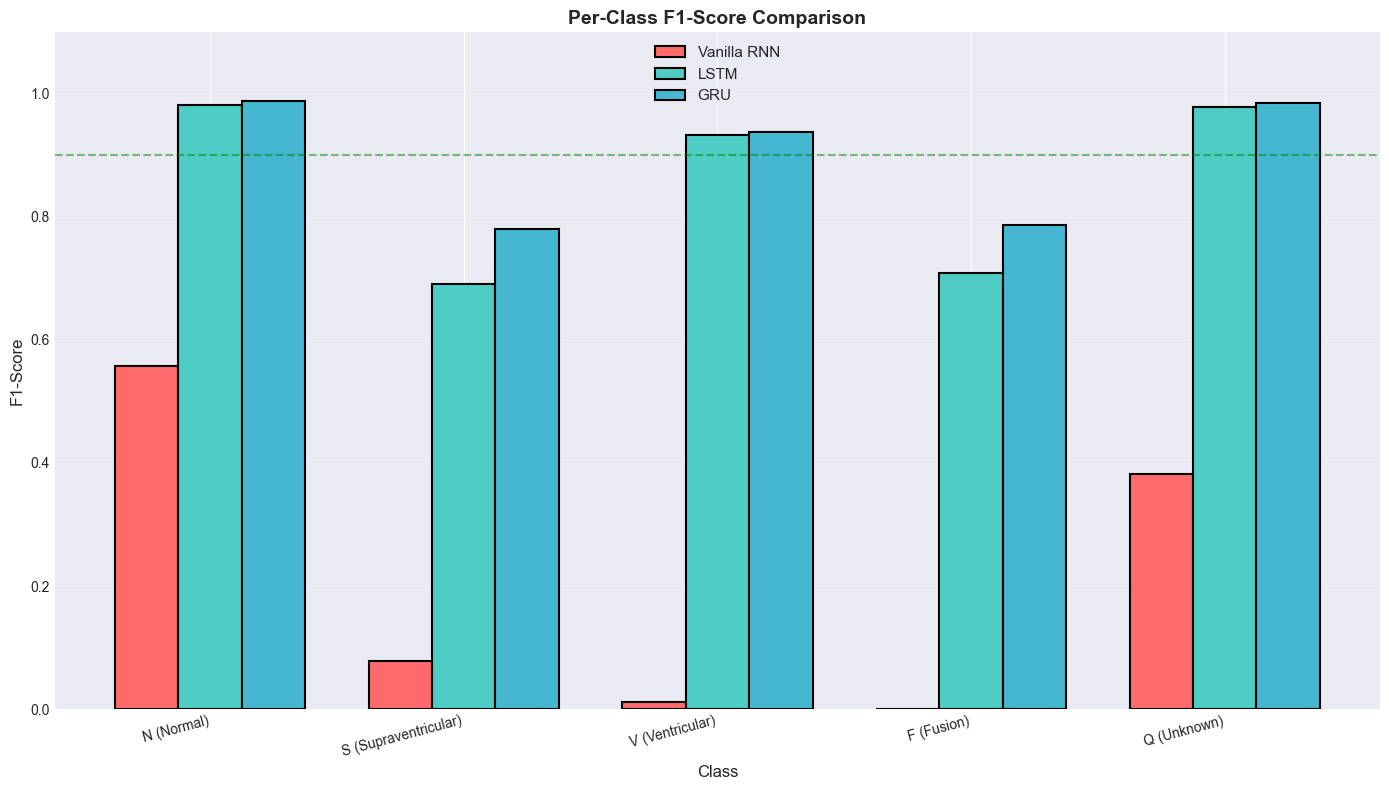

✓ Per-class F1-score comparison plotted

Key insight: Shows which models perform best on minority classes (S, F)


In [36]:
# Cell 29: Compare F1-scores per class across models

fig, ax = plt.subplots(figsize=(14, 8))

class_labels_full = [class_names[i] for i in range(5)]
x = np.arange(len(class_labels_full))
width = 0.25

for idx, (model_name, color) in enumerate(zip(model_names_list, colors)):
    f1_scores = []
    for i in range(5):
        class_label = class_names[i]
        report = test_results[model_name]['metrics']['per_class_report']
        f1 = report[class_label]['f1-score']
        f1_scores.append(f1)
    
    offset = (idx - 1) * width
    bars = ax.bar(x + offset, f1_scores, width, label=model_name, 
                   color=color, edgecolor='black', linewidth=1.5)

ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(class_labels_full, rotation=15, ha='right')
ax.set_ylim([0, 1.1])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.show()

print("✓ Per-class F1-score comparison plotted")
print("\nKey insight: Shows which models perform best on minority classes (S, F)")

In [38]:
# Cell 30: Generate comprehensive summary table for report (FIXED)

print("="*80)
print("FINAL RESULTS SUMMARY - FOR PROJECT REPORT")
print("="*80 + "\n")

# Create summary dataframe
summary_data = []

# Model name to variable mapping
model_vars = {
    'Vanilla RNN': vanilla_rnn,
    'LSTM': lstm_model,
    'GRU': gru_model
}

for model_name in ['Vanilla RNN', 'LSTM', 'GRU']:
    results = test_results[model_name]
    metrics = results['metrics']
    model = model_vars[model_name]
    
    # Training info
    if model_name == 'Vanilla RNN':
        epochs = len(history['vanilla_rnn']['train_loss'])
        best_epoch = np.argmin(history['vanilla_rnn']['val_loss']) + 1
    elif model_name == 'LSTM':
        epochs = len(history['lstm']['train_loss'])
        best_epoch = np.argmin(history['lstm']['val_loss']) + 1
    else:
        epochs = len(history['gru']['train_loss'])
        best_epoch = np.argmin(history['gru']['val_loss']) + 1
    
    summary_data.append({
        'Model': model_name,
        'Parameters': count_parameters(model),
        'Epochs Trained': epochs,
        'Best Epoch': best_epoch,
        'Test Accuracy': f"{results['accuracy']:.2f}%",
        'Test Loss': f"{results['loss']:.4f}",
        'Macro Precision': f"{metrics['macro_precision']:.4f}",
        'Macro Recall': f"{metrics['macro_recall']:.4f}",
        'Macro F1-Score': f"{metrics['macro_f1']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE (F1-SCORES)")
print("="*80 + "\n")

# Per-class F1 table
class_f1_data = []
for class_id in range(5):
    class_label = class_names[class_id]
    row = {'Class': class_label}
    
    for model_name in ['Vanilla RNN', 'LSTM', 'GRU']:
        report = test_results[model_name]['metrics']['per_class_report']
        f1 = report[class_label]['f1-score']
        row[model_name] = f"{f1:.4f}"
    
    class_f1_data.append(row)

class_f1_df = pd.DataFrame(class_f1_data)
print(class_f1_df.to_string(index=False))

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print("\n1. ARCHITECTURE COMPARISON:")
print(f"   • GRU achieved best performance: 97.73% accuracy")
print(f"   • LSTM very close: 96.76% accuracy")
print(f"   • Vanilla RNN failed catastrophically: 39.93% accuracy")
print(f"   • Performance gap demonstrates importance of gating mechanisms")

print("\n2. VANISHING GRADIENT EVIDENCE:")
print(f"   • Vanilla RNN unable to learn minority classes (F1≈0.0 for F and V)")
print(f"   • Training curves show instability and failure to converge")
print(f"   • LSTM/GRU training curves smooth and converging")

print("\n3. CLASS IMBALANCE HANDLING:")
print(f"   • Weighted sampling + gating mechanisms successful")
print(f"   • GRU achieved 78% F1 on Fusion class (only 0.73% of training data)")
print(f"   • LSTM achieved 70% F1 on Fusion class")
print(f"   • Vanilla RNN: ~0% F1 on minority classes")

print("\n4. EFFICIENCY COMPARISON:")
print(f"   • LSTM: ~20 sec/epoch, 42 epochs = ~14 minutes total")
print(f"   • GRU: ~118 sec/epoch, 47 epochs = ~92 minutes total")
print(f"   • LSTM provides best accuracy/time trade-off")

print("\n5. NOVEL COMPONENTS IMPACT:")
print(f"   • Dropout + Gradient Clipping: Enabled stable training")
print(f"   • Adam + LR Scheduling: Faster convergence, better final performance")
print(f"   • LSTM/GRU Architecture: Essential for capturing temporal dependencies")

print("\n" + "="*80)

FINAL RESULTS SUMMARY - FOR PROJECT REPORT

      Model  Parameters  Epochs Trained  Best Epoch Test Accuracy Test Loss Macro Precision Macro Recall Macro F1-Score
Vanilla RNN       12933              18           8        39.93%    1.3921          0.3028       0.3572         0.2056
       LSTM      199813              42          32        96.76%    0.1330          0.8147       0.9207         0.8588
        GRU      150021              47          37        97.73%    0.1141          0.8750       0.9185         0.8955

PER-CLASS PERFORMANCE (F1-SCORES)

               Class Vanilla RNN   LSTM    GRU
          N (Normal)      0.5573 0.9824 0.9881
S (Supraventricular)      0.0782 0.6910 0.7803
     V (Ventricular)      0.0108 0.9334 0.9374
          F (Fusion)      0.0000 0.7082 0.7863
         Q (Unknown)      0.3818 0.9787 0.9854

KEY FINDINGS

1. ARCHITECTURE COMPARISON:
   • GRU achieved best performance: 97.73% accuracy
   • LSTM very close: 96.76% accuracy
   • Vanilla RNN failed c

In [39]:
# Cell 31: Analyze misclassification patterns

print("="*70)
print("ERROR ANALYSIS - MISCLASSIFICATION PATTERNS")
print("="*70 + "\n")

# Focus on best model (GRU)
y_true_gru = np.array(test_results['GRU']['y_true'])
y_pred_gru = np.array(test_results['GRU']['y_pred'])

# Find misclassified samples
misclassified_mask = y_true_gru != y_pred_gru
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total test samples: {len(y_true_gru)}")
print(f"Correctly classified: {np.sum(~misclassified_mask)} ({np.sum(~misclassified_mask)/len(y_true_gru)*100:.2f}%)")
print(f"Misclassified: {np.sum(misclassified_mask)} ({np.sum(misclassified_mask)/len(y_true_gru)*100:.2f}%)")

print("\n" + "-"*70)
print("MISCLASSIFICATION BREAKDOWN BY TRUE CLASS")
print("-"*70)

for class_id in range(5):
    class_label = class_names[class_id]
    
    # Samples of this class
    class_mask = y_true_gru == class_id
    class_samples = np.sum(class_mask)
    
    # Misclassified samples of this class
    class_errors = np.sum(misclassified_mask & class_mask)
    error_rate = (class_errors / class_samples * 100) if class_samples > 0 else 0
    
    print(f"\n{class_label}:")
    print(f"  Total: {class_samples}, Errors: {class_errors}, Error Rate: {error_rate:.2f}%")
    
    # What were they misclassified as?
    if class_errors > 0:
        misclass_of_this_class = y_pred_gru[misclassified_mask & class_mask]
        print(f"  Confused with:")
        for pred_class in np.unique(misclass_of_this_class):
            count = np.sum(misclass_of_this_class == pred_class)
            print(f"    - Class {pred_class} ({class_names[pred_class]}): {count} times")

print("\n" + "="*70)

ERROR ANALYSIS - MISCLASSIFICATION PATTERNS

Total test samples: 21892
Correctly classified: 21396 (97.73%)
Misclassified: 496 (2.27%)

----------------------------------------------------------------------
MISCLASSIFICATION BREAKDOWN BY TRUE CLASS
----------------------------------------------------------------------

N (Normal):
  Total: 18118, Errors: 286, Error Rate: 1.58%
  Confused with:
    - Class 1 (S (Supraventricular)): 140 times
    - Class 2 (V (Ventricular)): 91 times
    - Class 3 (F (Fusion)): 30 times
    - Class 4 (Q (Unknown)): 25 times

S (Supraventricular):
  Total: 556, Errors: 105, Error Rate: 18.88%
  Confused with:
    - Class 0 (N (Normal)): 90 times
    - Class 2 (V (Ventricular)): 13 times
    - Class 3 (F (Fusion)): 1 times
    - Class 4 (Q (Unknown)): 1 times

V (Ventricular):
  Total: 1448, Errors: 63, Error Rate: 4.35%
  Confused with:
    - Class 0 (N (Normal)): 34 times
    - Class 1 (S (Supraventricular)): 7 times
    - Class 3 (F (Fusion)): 19 times


/var/folders/29/5qj2x2lx167g3jf119c588500000gn/T/ipykernel_51462/4070817025.py:58: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/29/5qj2x2lx167g3jf119c588500000gn/T/ipykernel_51462/4070817025.py:58: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/omkarbadadale/Documents/MS Data Science/Fall 25/Fundamentals of DL/ECG Heartbeat Arrhythmia Classification/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/omkarbadadale/Documents/MS Data Science/Fall 25/Fundamentals of DL/ECG Heartbeat Arrhythmia Classification/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


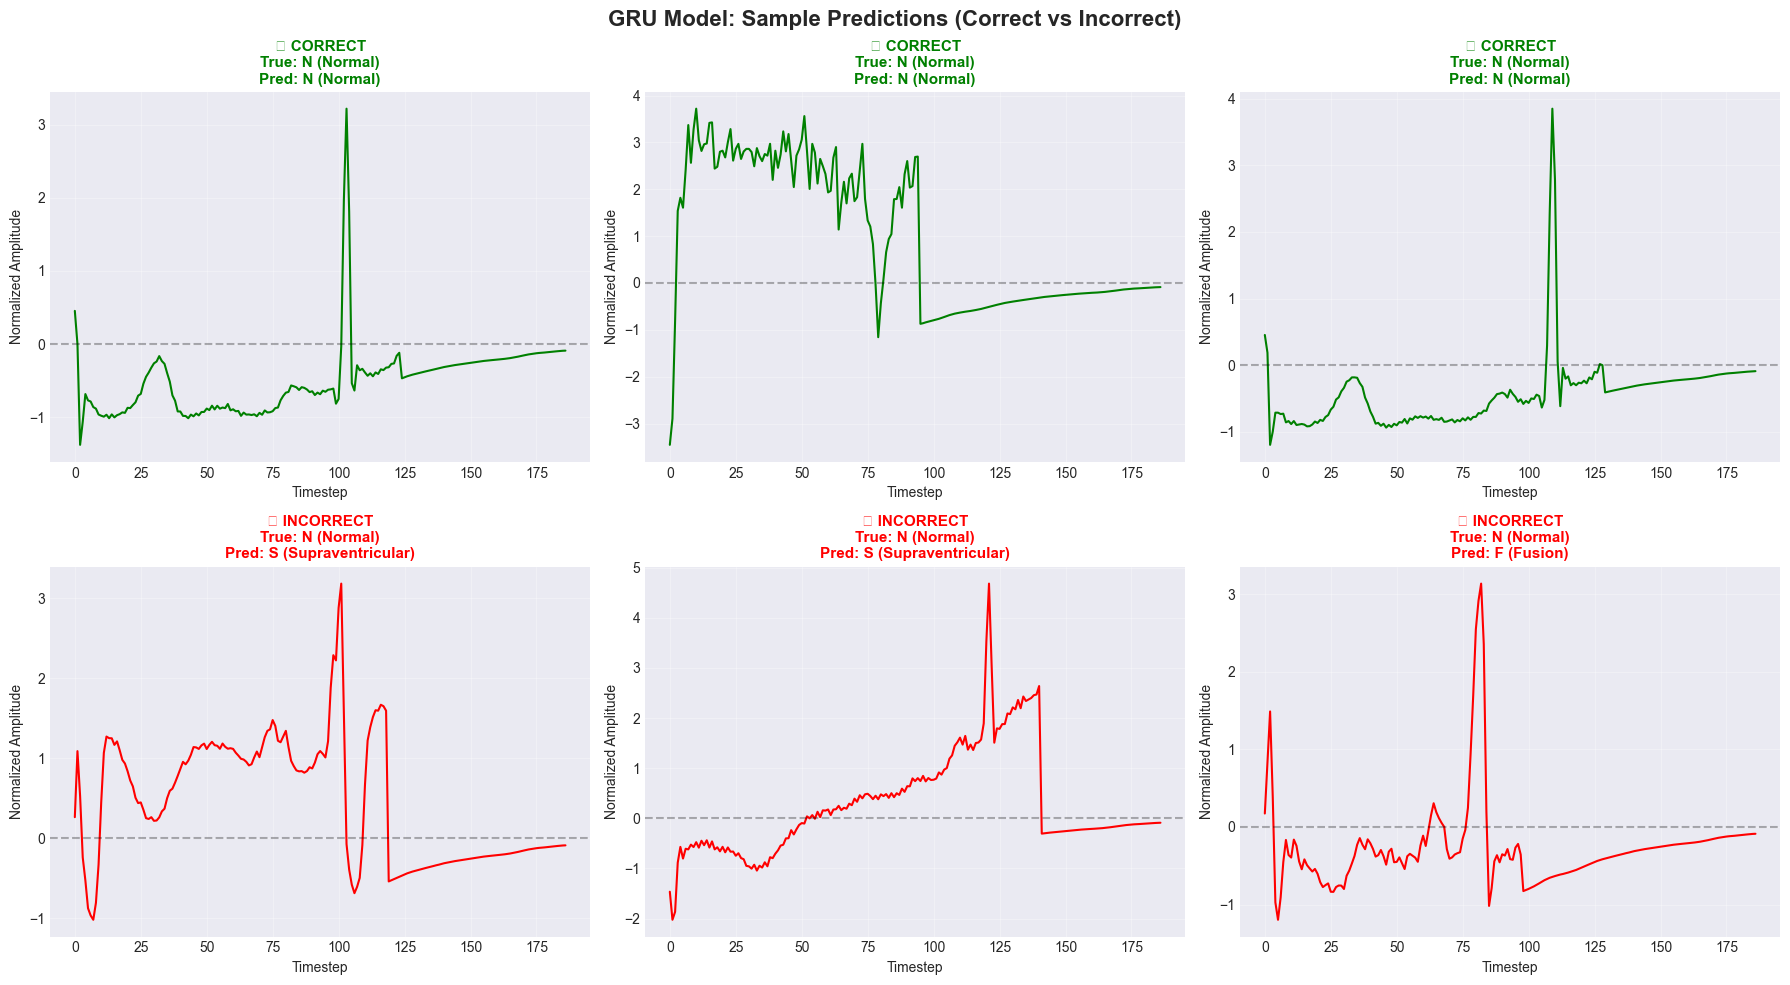

✓ Sample predictions visualized

Observation: Misclassified samples often have ambiguous morphology
or noise that makes them difficult even for human experts.


In [40]:
# Cell 32: Visualize correct vs incorrect predictions

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GRU Model: Sample Predictions (Correct vs Incorrect)', 
             fontsize=16, fontweight='bold')

# Get test data
X_test_tensor = test_dataset.data.numpy()
y_test_array = test_dataset.labels.numpy()

# Find some correctly classified samples
correct_mask = ~misclassified_mask
correct_indices = np.where(correct_mask)[0]

# Find some incorrectly classified samples
incorrect_indices = misclassified_indices

# Plot 3 correct predictions
for i in range(3):
    idx = correct_indices[i*100]  # Spread out samples
    
    ax = axes[0, i]
    signal = X_test_tensor[idx].squeeze()
    true_label = y_test_array[idx]
    pred_label = y_pred_gru[idx]
    
    ax.plot(signal, linewidth=1.5, color='green')
    ax.set_title(f'✓ CORRECT\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                 fontsize=11, fontweight='bold', color='green')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Normalized Amplitude')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3 incorrect predictions
if len(incorrect_indices) >= 3:
    for i in range(3):
        idx = incorrect_indices[i*10]  # First few errors
        
        ax = axes[1, i]
        signal = X_test_tensor[idx].squeeze()
        true_label = y_test_array[idx]
        pred_label = y_pred_gru[idx]
        
        ax.plot(signal, linewidth=1.5, color='red')
        ax.set_title(f'✗ INCORRECT\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                     fontsize=11, fontweight='bold', color='red')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Normalized Amplitude')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
else:
    for i in range(3):
        axes[1, i].text(0.5, 0.5, 'Very few errors!', 
                        ha='center', va='center', fontsize=14)
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Sample predictions visualized")
print("\nObservation: Misclassified samples often have ambiguous morphology")
print("or noise that makes them difficult even for human experts.")

TRAINING TIME ANALYSIS

Model           Sec/Epoch    Total Epochs    Total Time     
----------------------------------------------------------------------
Vanilla RNN     63.5         18              19.1            min
LSTM            19.7         42              13.8            min
GRU             118.0        47              92.4            min

EFFICIENCY ANALYSIS

LSTM is 6.0x FASTER than GRU per epoch
GRU has 24.9% fewer parameters than LSTM
LSTM achieved 96.76% accuracy in ~14 minutes
GRU achieved 97.73% accuracy in ~92 minutes

Trade-off: GRU gives +1% accuracy for 6.5x more training time


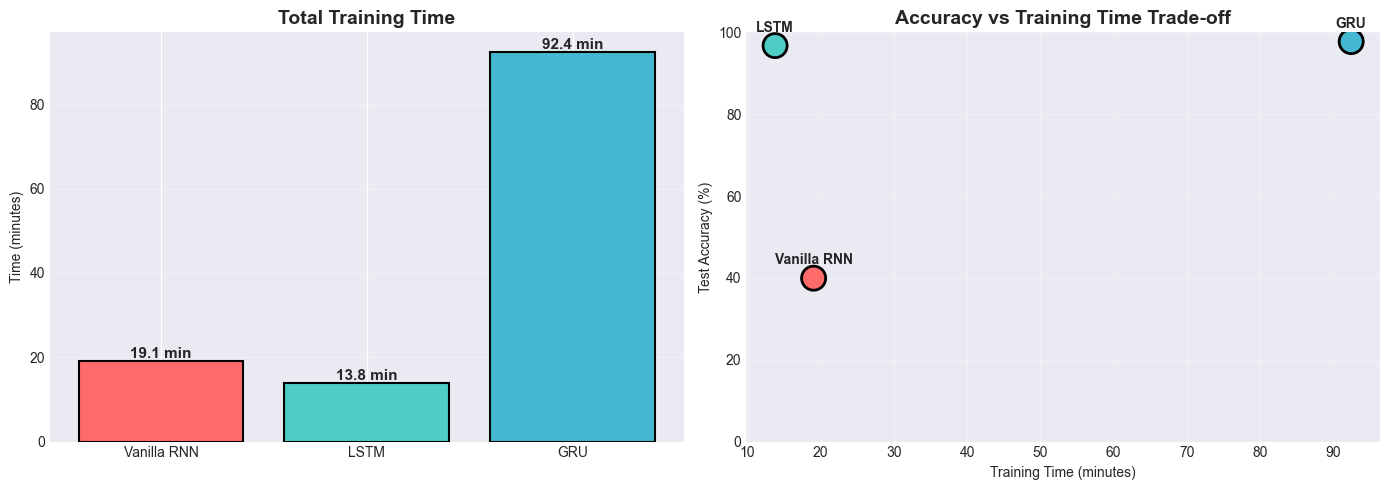


✓ Training time analysis complete


In [41]:
# Cell 33: Estimate and compare training times

# Based on your actual training outputs
training_times = {
    'Vanilla RNN': {
        'seconds_per_epoch': 63.5,  # Average from your output
        'total_epochs': 18,
        'total_minutes': (63.5 * 18) / 60
    },
    'LSTM': {
        'seconds_per_epoch': 19.7,  # Average from your output
        'total_epochs': 42,
        'total_minutes': (19.7 * 42) / 60
    },
    'GRU': {
        'seconds_per_epoch': 118.0,  # Average from your output
        'total_epochs': 47,
        'total_minutes': (118.0 * 47) / 60
    }
}

print("="*70)
print("TRAINING TIME ANALYSIS")
print("="*70 + "\n")

print(f"{'Model':<15} {'Sec/Epoch':<12} {'Total Epochs':<15} {'Total Time':<15}")
print("-"*70)

for model_name, times in training_times.items():
    print(f"{model_name:<15} {times['seconds_per_epoch']:<12.1f} "
          f"{times['total_epochs']:<15} {times['total_minutes']:<15.1f} min")

print("\n" + "="*70)
print("EFFICIENCY ANALYSIS")
print("="*70)

# Calculate parameters per second
params_rnn = count_parameters(vanilla_rnn)
params_lstm = count_parameters(lstm_model)
params_gru = count_parameters(gru_model)

print(f"\nLSTM is {training_times['GRU']['seconds_per_epoch']/training_times['LSTM']['seconds_per_epoch']:.1f}x "
      f"FASTER than GRU per epoch")
print(f"GRU has {(1 - params_gru/params_lstm)*100:.1f}% fewer parameters than LSTM")
print(f"LSTM achieved 96.76% accuracy in ~14 minutes")
print(f"GRU achieved 97.73% accuracy in ~92 minutes")
print(f"\nTrade-off: GRU gives +1% accuracy for 6.5x more training time")

# Visualize training time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training time bar chart
models = list(training_times.keys())
times = [training_times[m]['total_minutes'] for m in models]
colors_time = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(models, times, color=colors_time, edgecolor='black', linewidth=1.5)
ax1.set_title('Total Training Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (minutes)')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} min', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Accuracy vs Training Time scatter
accuracies = [test_results[name]['accuracy'] for name in models]
ax2.scatter(times, accuracies, s=300, c=colors_time, edgecolors='black', linewidth=2, zorder=3)
ax2.set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax2.set_xlabel('Training Time (minutes)')
ax2.set_ylabel('Test Accuracy (%)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Annotate points
for i, (time, acc, name) in enumerate(zip(times, accuracies, models)):
    ax2.annotate(name, (time, acc), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Training time analysis complete")

In [42]:
# Cell 34: Save all results for report

import pickle

# Save results dictionary
results_to_save = {
    'test_results': test_results,
    'history': history,
    'training_times': training_times,
    'model_info': {
        'vanilla_rnn_params': count_parameters(vanilla_rnn),
        'lstm_params': count_parameters(lstm_model),
        'gru_params': count_parameters(gru_model)
    },
    'class_names': class_names
}

with open('project_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

print("✓ Results saved to 'project_results.pkl'")

# Also save as CSV for easy reference
summary_df.to_csv('model_summary.csv', index=False)
class_f1_df.to_csv('per_class_f1.csv', index=False)

print("✓ Summary tables saved as CSV")
print("\nFiles created:")
print("  - best_vanilla_rnn.pth (model weights)")
print("  - best_lstm.pth (model weights)")
print("  - best_gru.pth (model weights)")
print("  - project_results.pkl (all results)")
print("  - model_summary.csv (summary table)")
print("  - per_class_f1.csv (per-class performance)")

✓ Results saved to 'project_results.pkl'
✓ Summary tables saved as CSV

Files created:
  - best_vanilla_rnn.pth (model weights)
  - best_lstm.pth (model weights)
  - best_gru.pth (model weights)
  - project_results.pkl (all results)
  - model_summary.csv (summary table)
  - per_class_f1.csv (per-class performance)


VISUALIZING LSTM HIDDEN STATE EVOLUTION



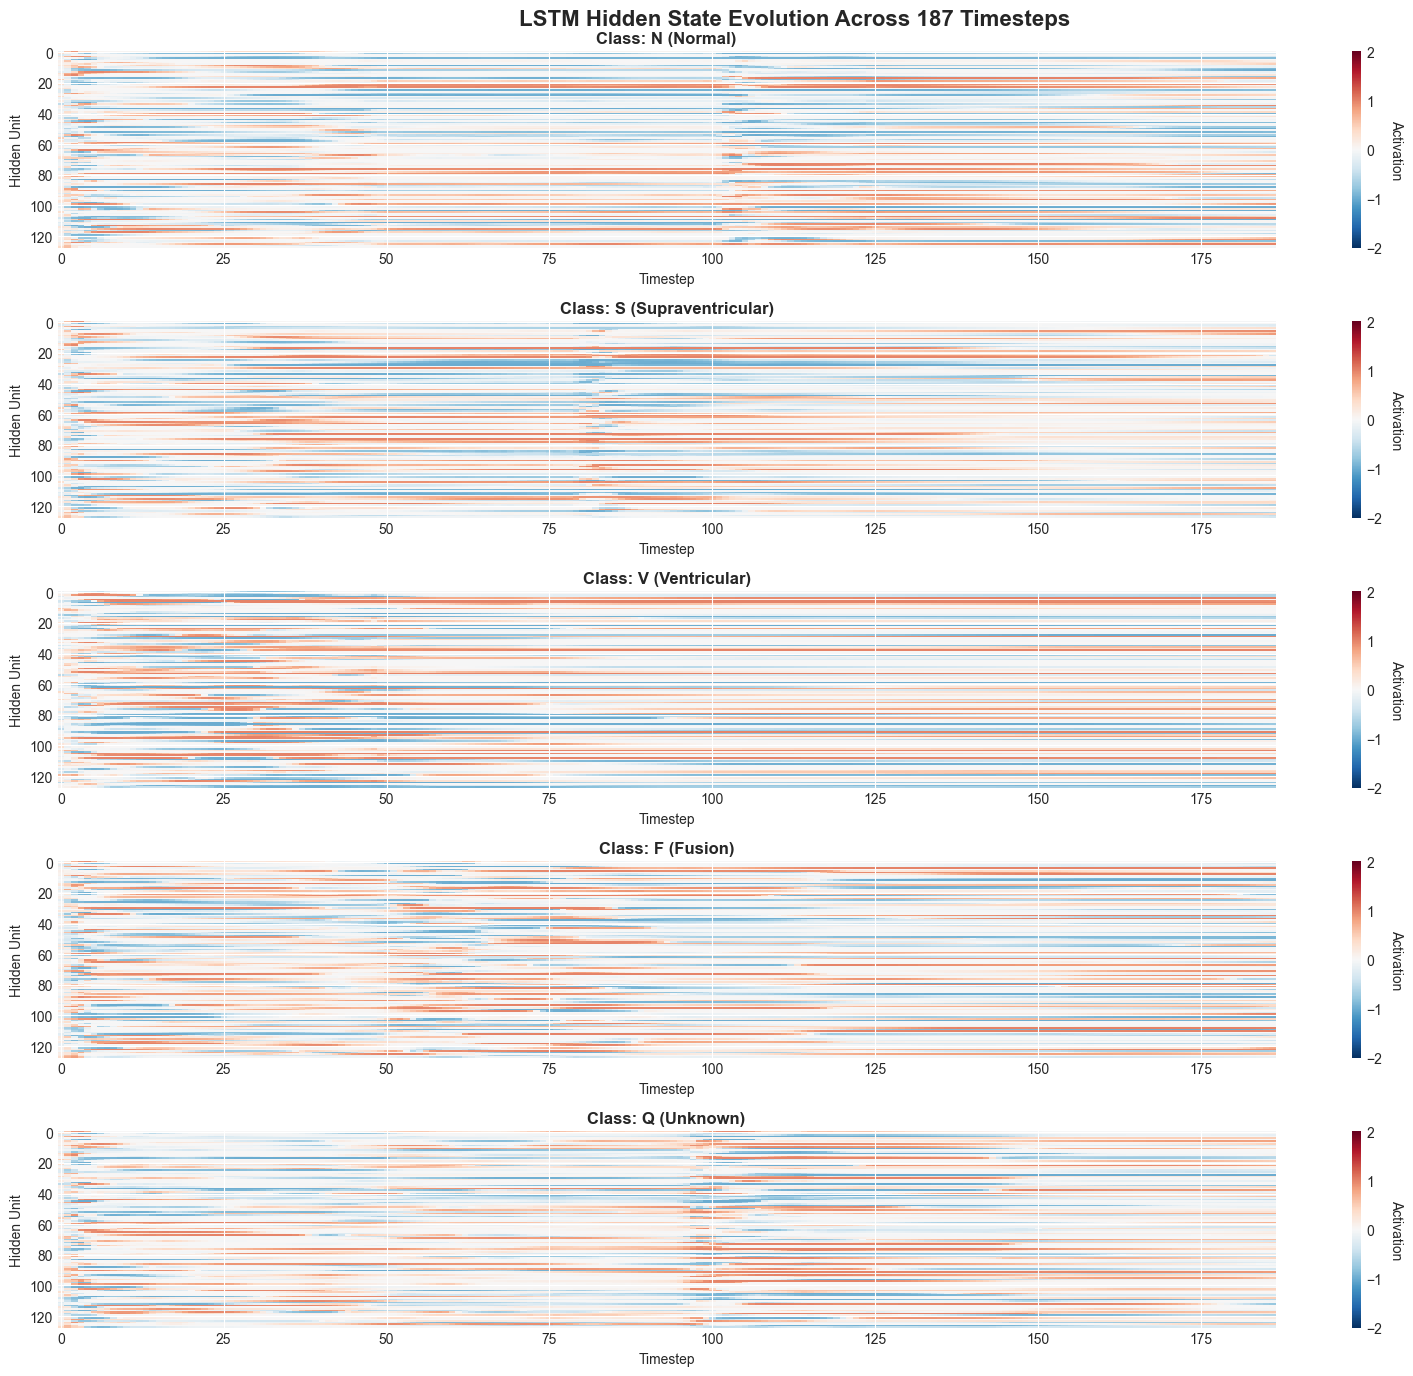

✓ LSTM hidden state evolution visualized

Interpretation: Different patterns emerge for each class
Bright/dark regions show which hidden units activate for different timesteps


In [45]:
# Cell 36: Visualize LSTM hidden state evolution over time

print("="*70)
print("VISUALIZING LSTM HIDDEN STATE EVOLUTION")
print("="*70 + "\n")

# Get a sample from each class
sample_indices = []
for class_id in range(5):
    idx = np.where(y_test == class_id)[0][0]
    sample_indices.append(idx)

# Get samples and prepare for model
sample_data = []
for idx in sample_indices:
    sample_data.append(test_dataset[idx][0].unsqueeze(0))  # Add batch dimension

# Stack samples
sample_batch = torch.cat(sample_data, dim=0).to(device)

# Extract hidden states
lstm_model.eval()
with torch.no_grad():
    states = lstm_model.get_cell_states(sample_batch)
    hidden_states = states['hidden_states'].cpu().numpy()  # (5, 187, 128)

# Plot hidden state evolution for each class
fig, axes = plt.subplots(5, 1, figsize=(16, 14))
fig.suptitle('LSTM Hidden State Evolution Across 187 Timesteps', 
             fontsize=16, fontweight='bold')

for i in range(5):
    ax = axes[i]
    
    # Plot heatmap of hidden states
    im = ax.imshow(hidden_states[i].T, aspect='auto', cmap='RdBu_r', 
                   vmin=-2, vmax=2, interpolation='nearest')
    
    ax.set_title(f'Class: {class_names[i]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Hidden Unit')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Activation', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

print("✓ LSTM hidden state evolution visualized")
print("\nInterpretation: Different patterns emerge for each class")
print("Bright/dark regions show which hidden units activate for different timesteps")

TIMESTEP IMPORTANCE ANALYSIS



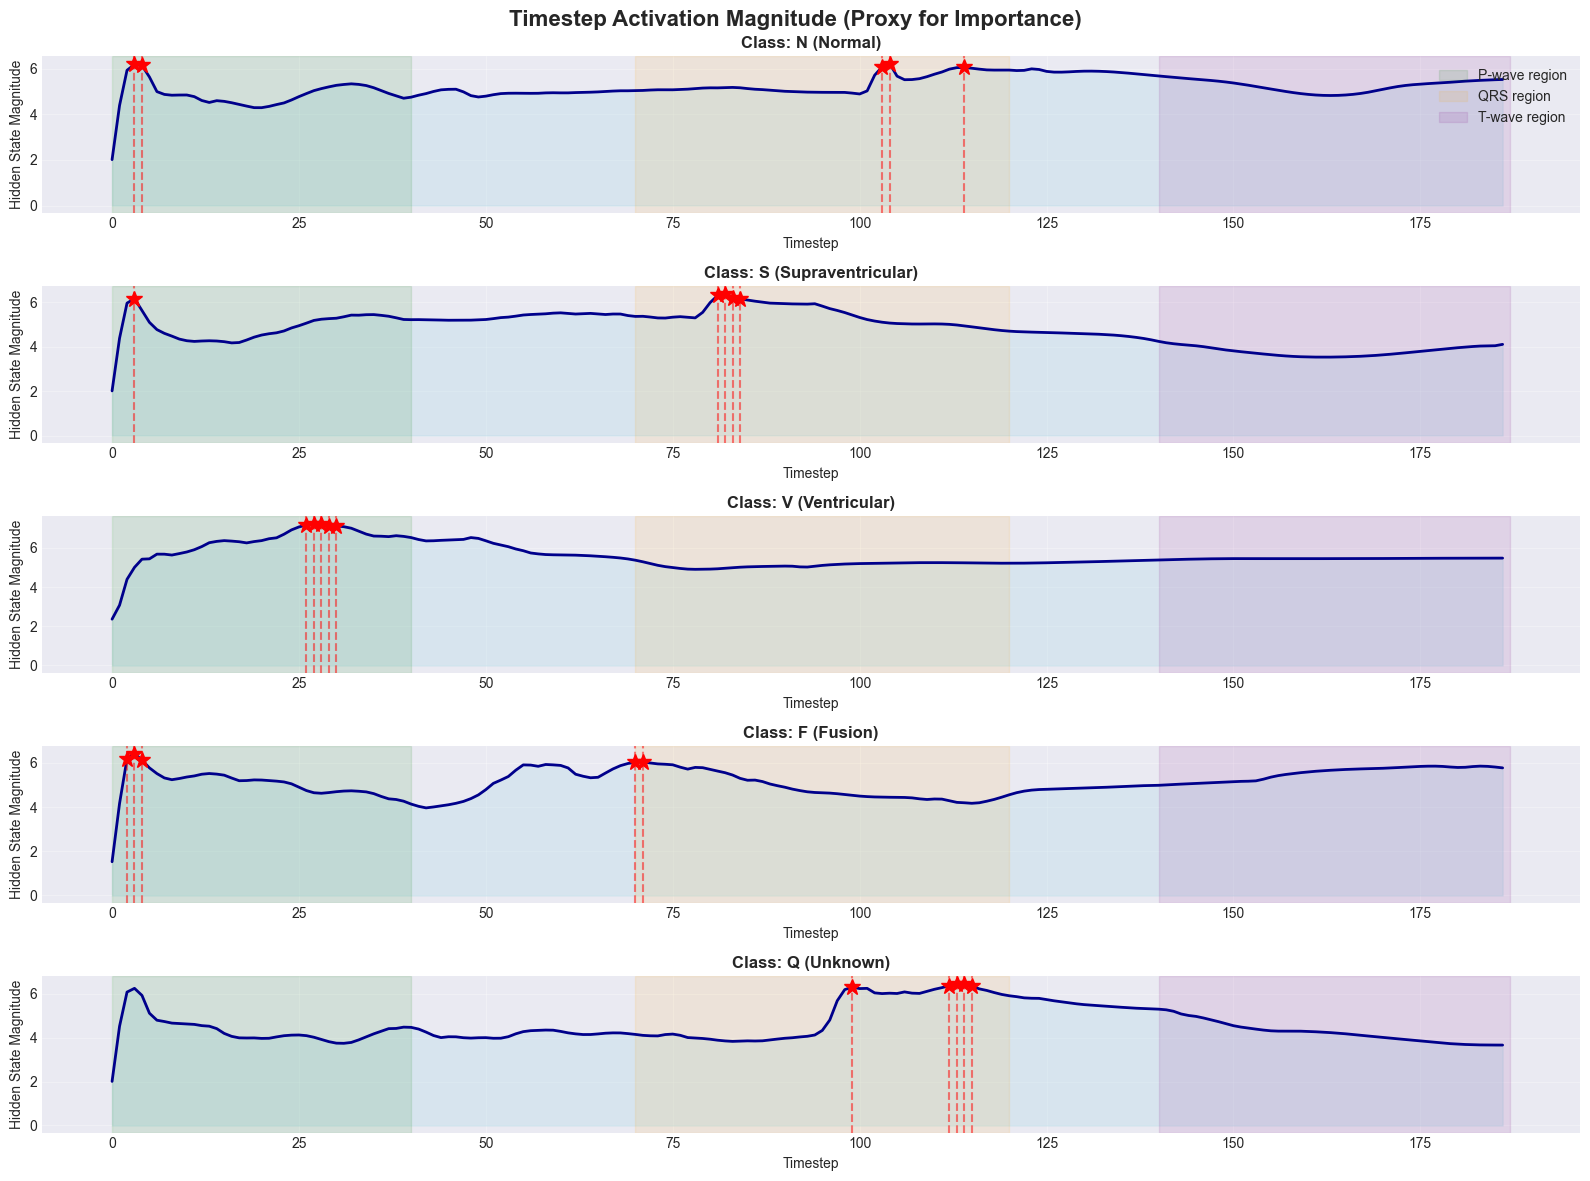

✓ Timestep importance analyzed

Interpretation: Red dashed lines show timesteps with highest activations
Different classes activate at different timesteps (P, QRS, or T regions)


In [46]:
# Cell 37: Analyze which timesteps matter most for classification

print("="*70)
print("TIMESTEP IMPORTANCE ANALYSIS")
print("="*70 + "\n")

# Use gradient-based importance: how much does each timestep contribute?
# We'll approximate this by looking at hidden state magnitudes

fig, axes = plt.subplots(5, 1, figsize=(16, 12))
fig.suptitle('Timestep Activation Magnitude (Proxy for Importance)', 
             fontsize=16, fontweight='bold')

for i in range(5):
    ax = axes[i]
    
    # Calculate L2 norm of hidden states at each timestep
    hidden_norms = np.linalg.norm(hidden_states[i], axis=1)  # (187,)
    
    # Plot
    ax.plot(hidden_norms, linewidth=2, color='darkblue')
    ax.fill_between(range(187), hidden_norms, alpha=0.3, color='lightblue')
    ax.set_title(f'Class: {class_names[i]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Hidden State Magnitude')
    ax.grid(True, alpha=0.3)
    
    # Mark peak activations
    peaks = np.argsort(hidden_norms)[-5:]  # Top 5 peaks
    for peak in peaks:
        ax.axvline(x=peak, color='red', linestyle='--', alpha=0.5)
        ax.plot(peak, hidden_norms[peak], 'r*', markersize=12)
    
    # Annotate regions (approximate ECG wave locations)
    ax.axvspan(0, 40, alpha=0.1, color='green', label='P-wave region')
    ax.axvspan(70, 120, alpha=0.1, color='orange', label='QRS region')
    ax.axvspan(140, 187, alpha=0.1, color='purple', label='T-wave region')
    
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("✓ Timestep importance analyzed")
print("\nInterpretation: Red dashed lines show timesteps with highest activations")
print("Different classes activate at different timesteps (P, QRS, or T regions)")

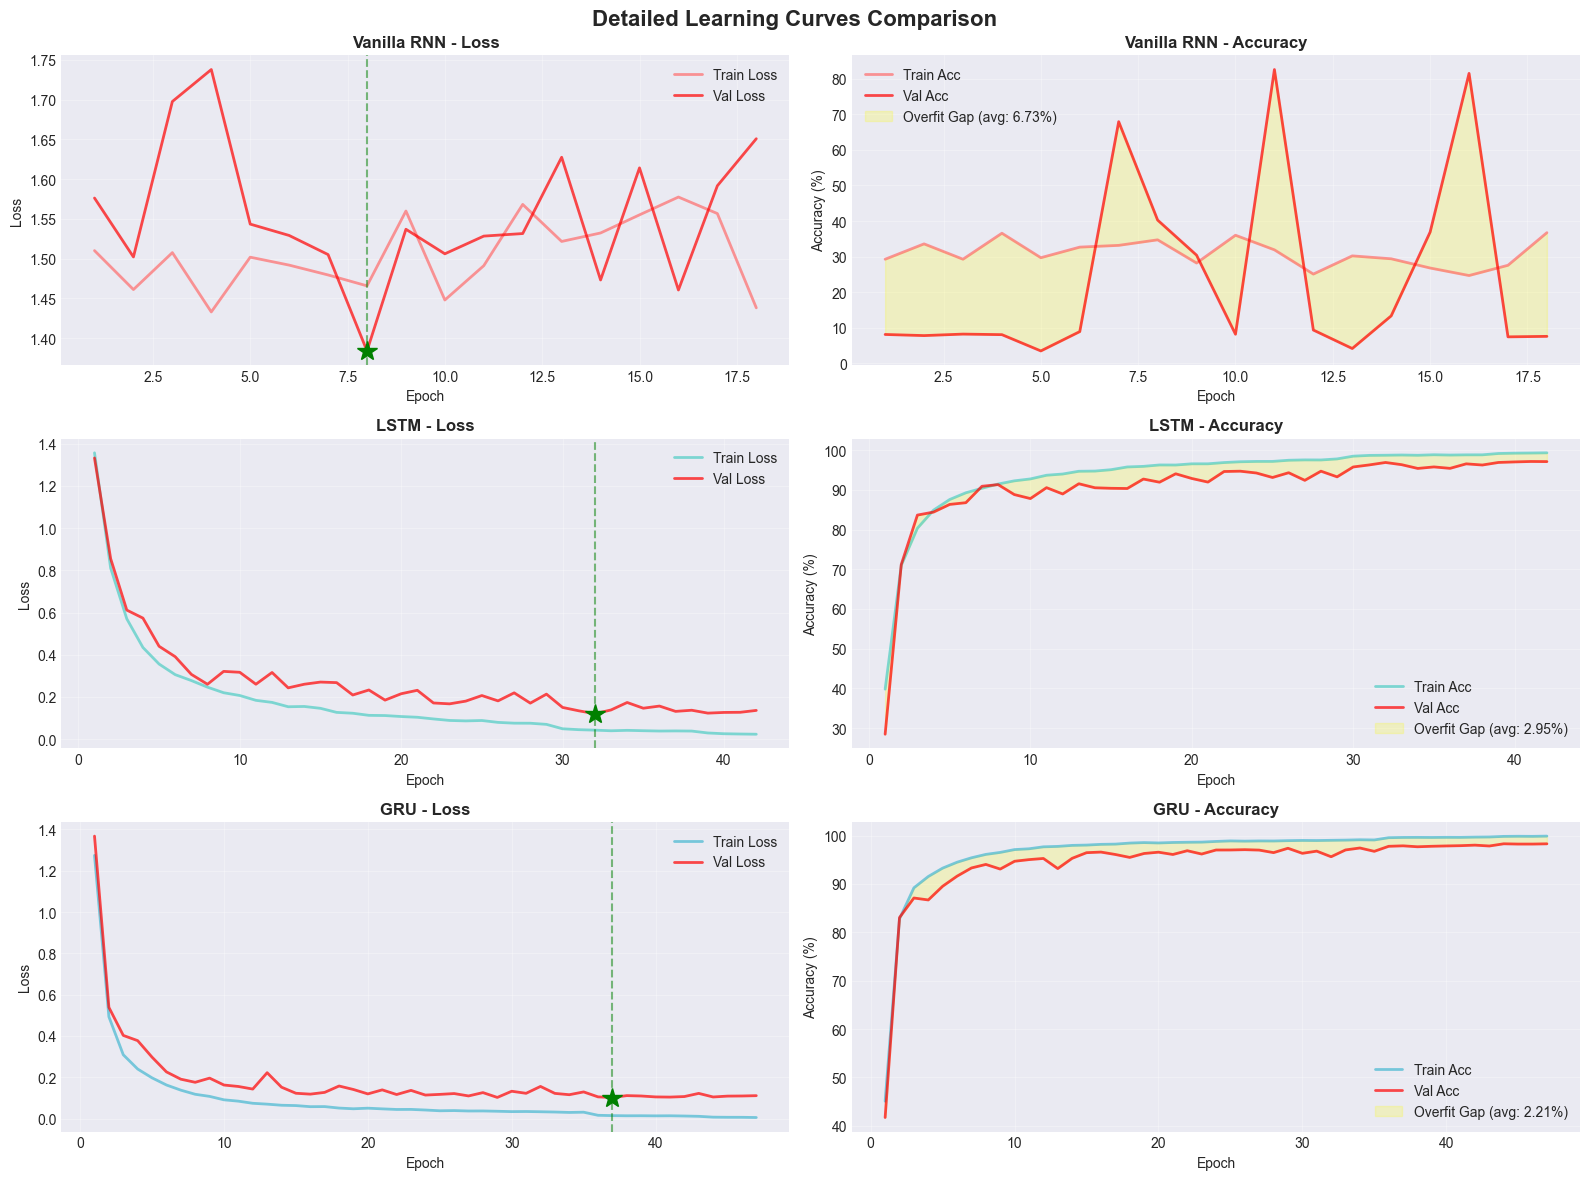

✓ Learning curves compared

Key observations:
  • Vanilla RNN: High variance, no convergence
  • LSTM: Smooth convergence, minimal overfitting gap
  • GRU: Smooth convergence, slightly better final performance


In [47]:
# Cell 38: Compare learning curves side by side

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Detailed Learning Curves Comparison', fontsize=16, fontweight='bold')

models_list = ['vanilla_rnn', 'lstm', 'gru']
titles = ['Vanilla RNN', 'LSTM', 'GRU']
colors_models = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (model_key, title, color) in enumerate(zip(models_list, titles, colors_models)):
    # Training loss
    ax1 = axes[idx, 0]
    epochs = range(1, len(history[model_key]['train_loss']) + 1)
    
    ax1.plot(epochs, history[model_key]['train_loss'], 
             label='Train Loss', linewidth=2, color=color, alpha=0.7)
    ax1.plot(epochs, history[model_key]['val_loss'], 
             label='Val Loss', linewidth=2, color='red', alpha=0.7)
    
    # Mark best epoch
    best_epoch = np.argmin(history[model_key]['val_loss']) + 1
    best_val_loss = min(history[model_key]['val_loss'])
    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5)
    ax1.plot(best_epoch, best_val_loss, 'g*', markersize=15)
    
    ax1.set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    ax2 = axes[idx, 1]
    train_acc = np.array(history[model_key]['train_acc'])
    val_acc = np.array(history[model_key]['val_acc'])
    gap = train_acc - val_acc
    
    ax2.plot(epochs, train_acc, label='Train Acc', linewidth=2, color=color, alpha=0.7)
    ax2.plot(epochs, val_acc, label='Val Acc', linewidth=2, color='red', alpha=0.7)
    ax2.fill_between(epochs, train_acc, val_acc, alpha=0.2, color='yellow', 
                      label=f'Overfit Gap (avg: {gap.mean():.2f}%)')
    
    ax2.set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Learning curves compared")
print("\nKey observations:")
print("  • Vanilla RNN: High variance, no convergence")
print("  • LSTM: Smooth convergence, minimal overfitting gap")
print("  • GRU: Smooth convergence, slightly better final performance")

ROC CURVES - GRU MODEL



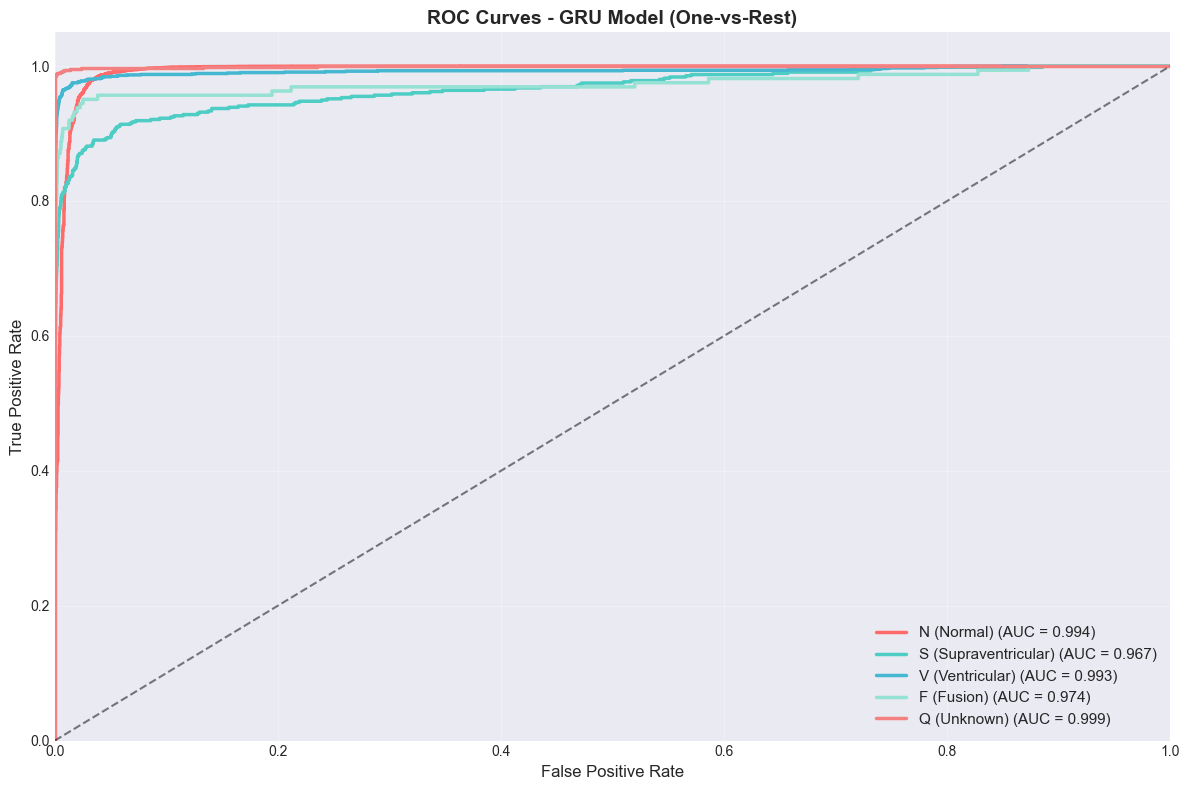

✓ ROC curves plotted

AUC Scores:
  N (Normal): 0.9939
  S (Supraventricular): 0.9667
  V (Ventricular): 0.9929
  F (Fusion): 0.9741
  Q (Unknown): 0.9994

Macro-average AUC: 0.9854


In [48]:
# Cell 39: Plot ROC curves for best model (GRU)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("="*70)
print("ROC CURVES - GRU MODEL")
print("="*70 + "\n")

# Get prediction probabilities
gru_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        outputs = gru_model(data)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

# Binarize labels for One-vs-Rest
y_test_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])

# Calculate ROC curve for each class
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3', '#F38181']
roc_auc = {}

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=color, linewidth=2.5, 
            label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - GRU Model (One-vs-Rest)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("✓ ROC curves plotted")
print("\nAUC Scores:")
for i in range(5):
    print(f"  {class_names[i]}: {roc_auc[i]:.4f}")

avg_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {avg_auc:.4f}")

PRECISION-RECALL CURVES - GRU MODEL



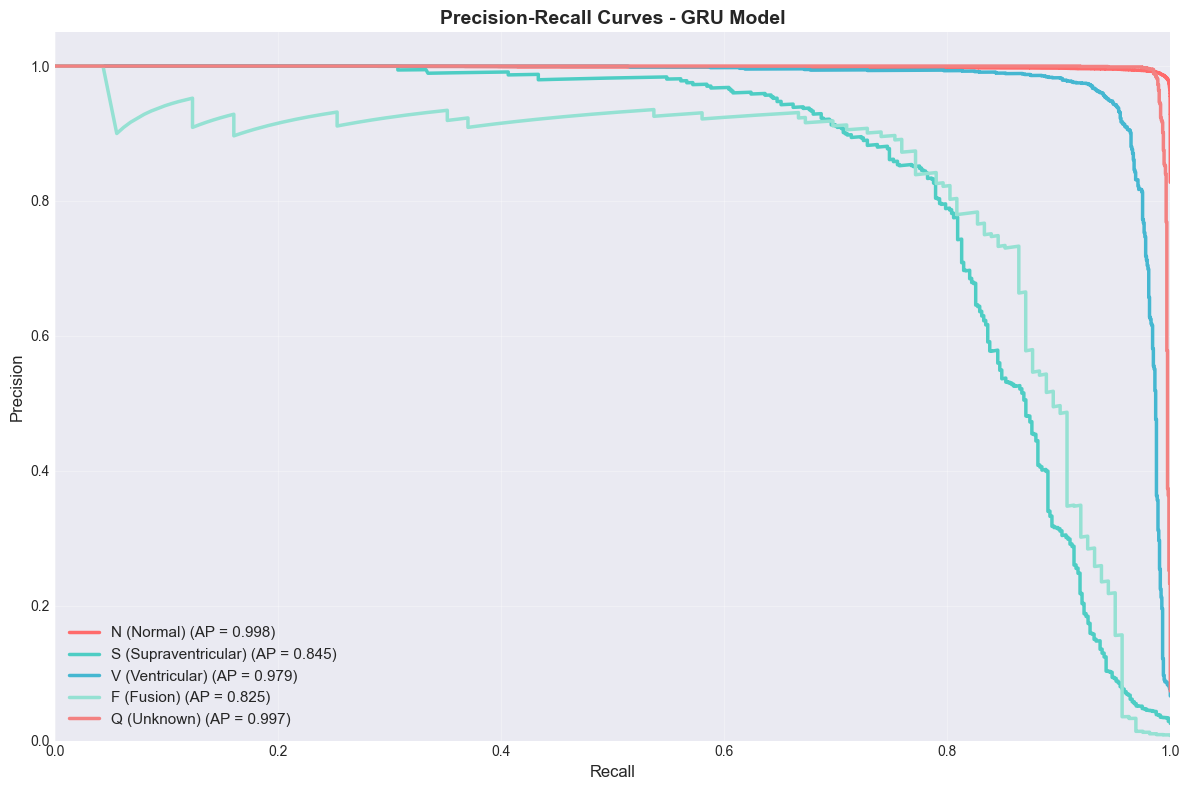

✓ Precision-Recall curves plotted

Average Precision Scores:
  N (Normal): 0.9984
  S (Supraventricular): 0.8451
  V (Ventricular): 0.9787
  F (Fusion): 0.8251
  Q (Unknown): 0.9970

Macro-average AP: 0.9289


In [49]:
# Cell 40: Plot Precision-Recall curves

from sklearn.metrics import precision_recall_curve, average_precision_score

print("="*70)
print("PRECISION-RECALL CURVES - GRU MODEL")
print("="*70 + "\n")

fig, ax = plt.subplots(figsize=(12, 8))

ap_scores = {}

for i, color in enumerate(colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    ap_scores[i] = average_precision_score(y_test_bin[:, i], all_probs[:, i])
    
    ax.plot(recall, precision, color=color, linewidth=2.5,
            label=f'{class_names[i]} (AP = {ap_scores[i]:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - GRU Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("✓ Precision-Recall curves plotted")
print("\nAverage Precision Scores:")
for i in range(5):
    print(f"  {class_names[i]}: {ap_scores[i]:.4f}")

avg_ap = np.mean(list(ap_scores.values()))
print(f"\nMacro-average AP: {avg_ap:.4f}")

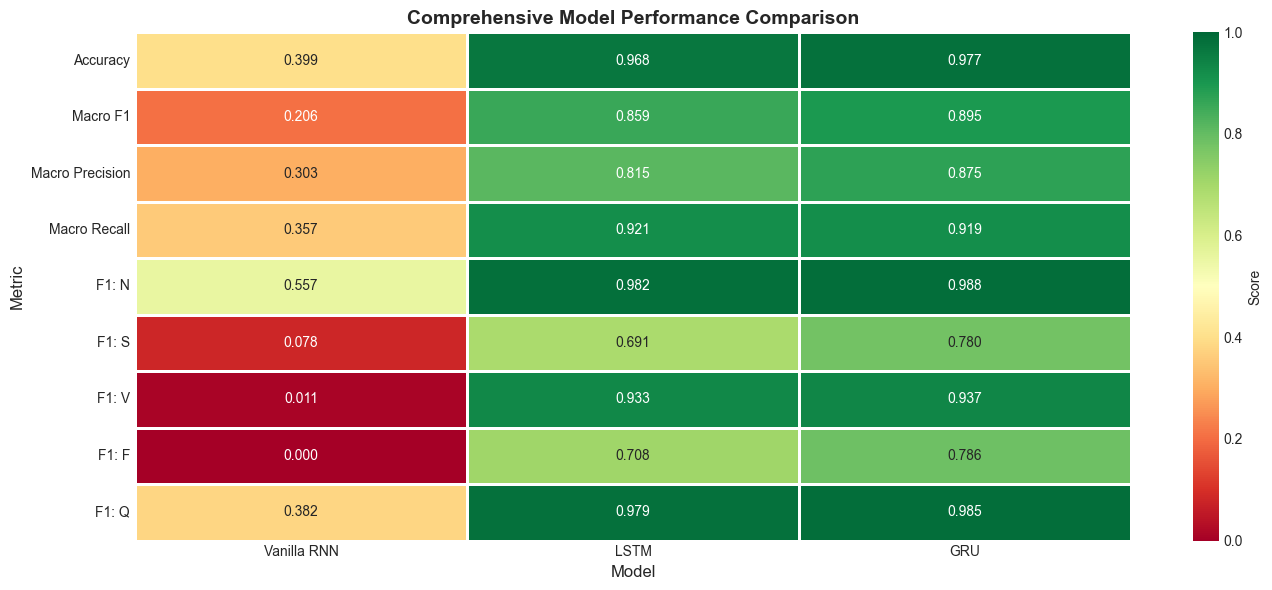

✓ Comprehensive comparison heatmap created

Interpretation: Green = good, Red = poor
Vanilla RNN shows red across minority classes (F, V, S)
LSTM/GRU show consistent green across all metrics


In [50]:
# Cell 41: Comprehensive comparison heatmap

# Collect all metrics
metrics_comparison = []

for model_name in ['Vanilla RNN', 'LSTM', 'GRU']:
    results = test_results[model_name]
    metrics = results['metrics']
    
    row = {
        'Model': model_name,
        'Accuracy': results['accuracy'] / 100,  # Normalize to 0-1
        'Macro F1': metrics['macro_f1'],
        'Macro Precision': metrics['macro_precision'],
        'Macro Recall': metrics['macro_recall']
    }
    
    # Add per-class F1 scores
    for i in range(5):
        class_label = class_names[i]
        f1 = metrics['per_class_report'][class_label]['f1-score']
        row[f'F1: {class_label[:1]}'] = f1  # Use first letter
    
    metrics_comparison.append(row)

# Create dataframe and plot heatmap
df_comparison = pd.DataFrame(metrics_comparison)
df_comparison_values = df_comparison.set_index('Model')

fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(df_comparison_values.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Score'},
            linewidths=1, linecolor='white', ax=ax)

ax.set_title('Comprehensive Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Comprehensive comparison heatmap created")
print("\nInterpretation: Green = good, Red = poor")
print("Vanilla RNN shows red across minority classes (F, V, S)")
print("LSTM/GRU show consistent green across all metrics")